In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import xarray as xr
import netCDF4 as nc
from matplotlib import ticker, cm
from matplotlib import animation, rc
import matplotlib.tri as tri
import sys
#import metpy.calc as mpcalc
#from metpy.cbook import get_test_data
#from metpy.interpolate import cross_section
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.setrecursionlimit(9000)
import scipy.ndimage
import statistics
import scipy.io
import h5py
from scipy.interpolate import griddata

In [2]:
# Change this part
sYear  = 2008
sMonth = 10
sDay   = 1
sHour  = 0
eYear  = 2008
eMonth = 10
eDay   = 7
eHour  = 0
# Set the location of the column
Center_lon = 5  # 417
Center_lat = -11.0 
Center_lon0 = 5
Center_lat0 = -11.0 

#Center_lon = 102  # 1194
#Center_lat = -30.0 
#Center_lon0 = 102
#Center_lat0 = -30.0  

#Center_lon = 272 #3426
#Center_lat = -14.0 
#Center_lon0 = 272
#Center_lat0 = -14.0  

In [3]:
UPsedi15_PATH = '/media/liran/PLR5/UPsedi/fixed15/'
UPhysedi15 = xr.open_mfdataset(UPsedi15_PATH+'HPhypersedi_sigmag_long_fixed15_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPsedi20_PATH = '/media/liran/PLR5/UPsedi/fixed20/'
UPhysedi20 = xr.open_mfdataset(UPsedi20_PATH+'HPhypersedi_sigmag_long_fixed20_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPhy_PATH = '/media/liran/Elements/Frontera_Cases/Peter_smooth_momentum/Ensemble/2008/'
UPhy2008 = xr.open_mfdataset(UPhy_PATH+'Multi-CRM_UPCTRL_hpv_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_125z200m.2s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-*.nc')

In [4]:
UP_Case = 'Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
UP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_UP/Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
UP2008 = xr.open_mfdataset(UP_PATH+UP_Case+'.cam.h0.2008-10-*.nc')
SP_Case = 'Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
SP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_SP/Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.2008-10-*.nc')

In [5]:
lon = SP2008.lon.isel(time=0).values
lat = SP2008.lat.isel(time=0).values
Z3 = SP2008.Z3.isel(time=0).values

In [6]:
# Function calculate the distance between two points
def distance2(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [7]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [8]:
# Function calculate the distance between two points
def distancef(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [9]:
# Function calculate the distance between two points
def lonlat_in(lat, lon, lat1, lon1, lat2, lon2):
    flag = 0
    if lon >lon1:
        if lon <lon2:
            if lat >lat1:
                if lat <lat2:
                    flag = 1
    return flag

In [78]:
# Function calculate the distance between two points
def potential_temperature(Temperature_K,Pressure_Pa):
    kapa = 0.286
    P0 = 100000
    return Temperature_K*(P0/Pressure_Pa)**kapa

In [10]:
# UP ==============================================================
T_UP = UP2008.T.values # T vertical diffusion K/s
SPWWUP = UP2008.SPWW.values
CLOUD_UP  = UP2008.CLOUD.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
Q_UP  = UP2008.Q.values
TMQ_UP  = UP2008.TMQ.values
QRS_UP  = UP2008.QRS.values
QRL_UP  = UP2008.QRL.values
PTTEND_UP  = UP2008.PTTEND.values
Z3UP  = UP2008.Z3.values
# SP ==============================================================
T_SP = SP2008.T.values # T vertical diffusion K/s
SPWWSP = SP2008.SPWW.values
CLOUD_SP  = SP2008.CLOUD.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
Q_SP  = SP2008.Q.values
TMQ_SP  = SP2008.TMQ.values
QRS_SP  = SP2008.QRS.values
QRL_SP  = SP2008.QRL.values
PTTEND_SP  = SP2008.PTTEND.values
Z3SP  = SP2008.Z3.values
# UPhy ============================================================
T_UPhy = UPhy2008.T.values # T vertical diffusion K/s
SPWWUPhy = UPhy2008.SPWW.values
CLOUD_UPhy  = UPhy2008.CLOUD.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
Q_UPhy  = UPhy2008.Q.values
TMQ_UPhy  = UPhy2008.TMQ.values
QRS_UPhy  = UPhy2008.QRS.values
QRL_UPhy  = UPhy2008.QRL.values
PTTEND_UPhy  = UPhy2008.PTTEND.values
Z3UPhy  = UPhy2008.Z3.values
# UPhysedi15 ======================================================
T_UPhysedi15 = UPhysedi15.T.values # T vertical diffusion K/s
SPWWUPhysedi15 = UPhysedi15.SPWW.values
CLOUD_UPhysedi15  = UPhysedi15.CLOUD.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
Q_UPhysedi15  = UPhysedi15.Q.values
TMQ_UPhysedi15  = UPhysedi15.TMQ.values
QRS_UPhysedi15  = UPhysedi15.QRS.values
QRL_UPhysedi15  = UPhysedi15.QRL.values
PTTEND_UPhysedi15  = UPhysedi15.PTTEND.values
Z3UPhysedi15  = UPhysedi15.Z3.values
# UPhysedi20 ======================================================
T_UPhysedi20 = UPhysedi20.T.values # T vertical diffusion K/s
SPWWUPhysedi20 = UPhysedi20.SPWW.values
CLOUD_UPhysedi20  = UPhysedi20.CLOUD.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
Q_UPhysedi20  = UPhysedi20.Q.values
TMQ_UPhysedi20  = UPhysedi20.TMQ.values
QRS_UPhysedi20  = UPhysedi20.QRS.values
QRL_UPhysedi20  = UPhysedi20.QRL.values
PTTEND_UPhysedi20  = UPhysedi20.PTTEND.values
Z3UPhysedi20  = UPhysedi20.Z3.values
#  ======================================================
OCNFRAC = UPhysedi20.OCNFRAC.isel(time=0).values
#  ======================================================
hyam_SP  = SP2008.hyam.values
hyam_UP  = UP2008.hyam.values
hyam_UPhy  = UPhy2008.hyam.values
hyam_UPhysedi15  = UPhysedi15.hyam.values
hyam_UPhysedi20  = UPhysedi20.hyam.values
hybm_SP  = SP2008.hybm.values
hybm_UP  = UP2008.hybm.values
hybm_UPhy  = UPhy2008.hybm.values
hybm_UPhysedi15  = UPhysedi15.hybm.values
hybm_UPhysedi20  = UPhysedi20.hybm.values
P0_SP  = SP2008.P0.values
P0_UP  = UP2008.P0.values
P0_UPhy  = UPhy2008.P0.values
P0_UPhysedi15  = UPhysedi15.P0.values
P0_UPhysedi20  = UPhysedi20.P0.values
PS_SP  = SP2008.PS.values
PS_UP  = UP2008.PS.values
PS_UPhy  = UPhy2008.PS.values
PS_UPhysedi15  = UPhysedi15.PS.values
PS_UPhysedi20  = UPhysedi20.PS.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
CLDICE_SP  = SP2008.CLDICE.values
CLDICE_UP  = UP2008.CLDICE.values
CLDICE_UPhy  = UPhy2008.CLDICE.values
CLDICE_UPhysedi15  = UPhysedi15.CLDICE.values
CLDICE_UPhysedi20  = UPhysedi20.CLDICE.values
level_SP  = SP2008.lev.values
level_UP  = UP2008.lev.values
level_UPhy  = UPhy2008.lev.values
level_UPhysedi15  = UPhysedi15.lev.values
level_UPhysedi20  = UPhysedi20.lev.values

In [11]:
CERES_PATH = '/media/liran/Elements/CERES/'
count = 0
ndays = 7
iy = 2008
CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
toa_sw_all_daily = CERES_FILE.variables['toa_sw_all_daily']
toa_lw_all_daily = CERES_FILE.variables['toa_lw_all_daily']
toa_solar_all_daily = CERES_FILE.variables['toa_solar_all_daily']
if count ==0: 
    fsntoa_obs      = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    toa_lw_obs      = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
else:
    work1           = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    work2           = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
    fsntoa_obs      = fsntoa_obs+work1
    toa_lw_obs      = toa_lw_obs+work2
print(count)
fsntoa_obs = fsntoa_obs
toa_lw_obs = toa_lw_obs
fsntoa_obs_mean = np.mean(fsntoa_obs, axis=0)
toa_lw_obs_mean = np.mean(toa_lw_obs, axis=0)
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

0


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':


In [12]:
# ERA5 data  ---------------------------------------------------------------------------------------------------
iy = 2008
ndays = 7
sDay = 1
eDay = 7
ERA5_Path = '/media/liran/PLR5/ERA5/'+str(iy)+'/'
ERA5_Ensemblelcc = np.zeros([7,24,721,1440])
ERA5_Ensemblelwp = np.zeros([7,24,721,1440])
for id in range(sDay,eDay+1,1):
    ERA5_files = xr.open_mfdataset(ERA5_Path+'ERA5_sfc_'+str(iy)+'10'+str(id).zfill(2)+'.nc')
    ERA5_hourly = ERA5_files.variables['lcc']
    ERA5_hourly2 = ERA5_files.variables['tclw']
    ERA5_Ensemblelcc[id-1,:,:,:] = ERA5_hourly
    ERA5_Ensemblelwp[id-1,:,:,:] = ERA5_hourly2

lon_ERA5  = ERA5_files.variables['longitude'] # 360
lat_ERA5  = ERA5_files.variables['latitude'] # 180Multi-CRM_Aqua_UPCTRL5_1month_frontera_ne16pg2_ne16pg2_CRM1_64_125z_200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera
xi = lon_ERA5[:]
yi = lat_ERA5[:]
XiERA5, YiERA5 = np.meshgrid(lon_ERA5, lat_ERA5)
XiERA5_1d = XiERA5.flatten()
YiERA5_1d = YiERA5.flatten()

ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [13]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_cc.nc')
ERA5_cchourly = ERA5_plfiles.variables['cc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_t.nc')
ERA5_thourly = ERA5_plfiles.variables['t']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_q.nc')
ERA5_qhourly = ERA5_plfiles.variables['q']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_ciwc.nc')
ERA5_ciwchourly = ERA5_plfiles.variables['ciwc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_z.nc')
ERA5_zhourly = ERA5_plfiles.variables['z']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_clwc.nc')
ERA5_clwchourly = ERA5_plfiles.variables['clwc']

In [14]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [15]:
ind_Australian_ERA5 = [-999]
ind_Namibian_ERA5 = [-999] 
ind_Peruvian_ERA5 = [-999]
for il in range(len(XiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-39,94,-20,109) # Australian
    if d0>0:
        ind_Australian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,0,0,20) # Namibian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Namibian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,350,0,360) # Namibian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Namibian_ERA5.append(il)
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-30,265,-8,290) # Peruvian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Peruvian_ERA5.append(il)

ind_Australian_ERA5 = ind_Australian_ERA5[1:]
ind_Namibian_ERA5 = ind_Namibian_ERA5[1:]
ind_Peruvian_ERA5 = ind_Peruvian_ERA5[1:]

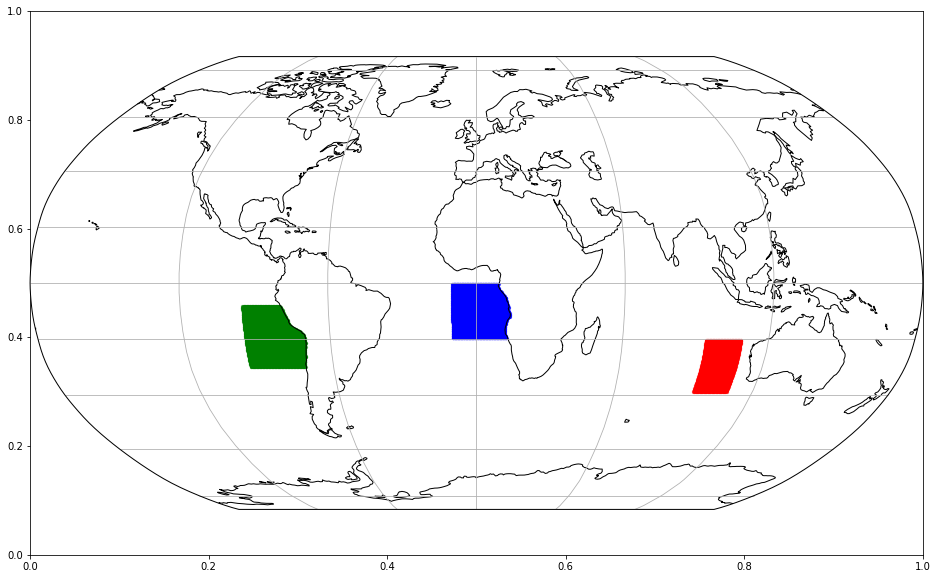

In [16]:
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()
for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-39,94,-20,109) # Australian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="red",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,0,0,20) # Namibian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
        
for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,350,0,360) # Namibian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-30,265,-8,290) # Peruvian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
plt.savefig('Ocean_Land_Namibian_Peruvian_Australian_ERA5.png')

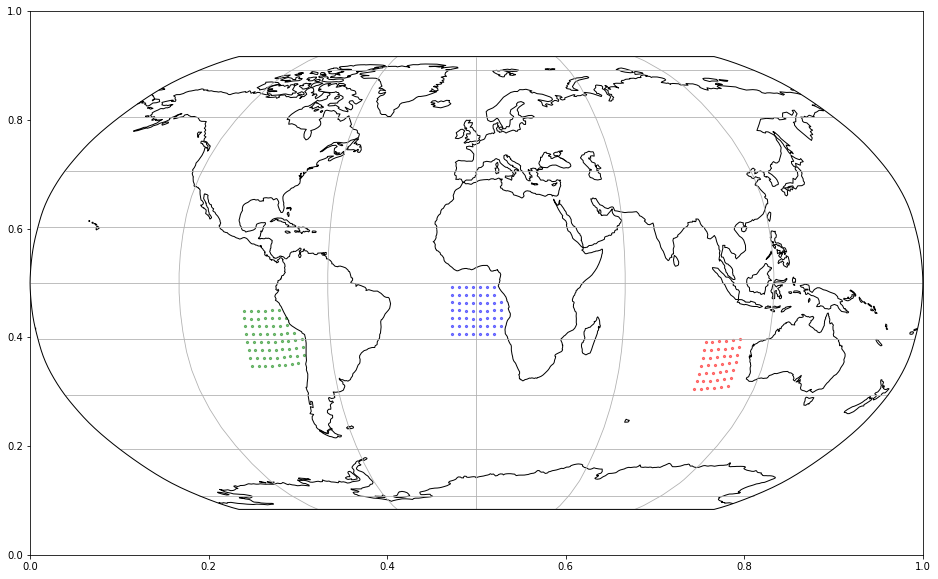

In [17]:
# Check the location of the selected column
#-- create figure and axes object
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()

ind_Namibian = [-999]        
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-20,0,0,20) # Namibian
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Namibian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
    d0 = lonlat_in(lat[il], lon[il],-20,350,0,360) # Namibian
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Namibian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Peruvian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-30,265,-8,290) # Peruvian
    if OCNFRAC[il]>0.5:
        if d0>0:
            ind_Peruvian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Australian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-39,94,-20,109) # Australian
    if d0>0:
        ind_Australian.append(il)
        plt.scatter(lon[il], lat[il],
                    color="red",
                    s=5,
                    alpha=0.5,
                    transform=ccrs.PlateCarree()) ## Important
        
        

plt.savefig('Ocean_Land_Namibian_Peruvian_Australian_Model.png')

In [18]:
ind_Peruvian = ind_Peruvian[1:]
ind_Namibian = ind_Namibian[1:]
ind_Australian = ind_Australian[1:]

# Peruvian 

In [117]:
spww_SPPeruvian = np.zeros([1009,125])
spww_UPPeruvian = np.zeros([1009,125])
spww_UPhyPeruvian = np.zeros([1009,125])
spww_UPhysedi20Peruvian = np.zeros([1009,125])
spww_UPhysedi15Peruvian = np.zeros([1009,125])
Z3_SPPeruvian = np.zeros([1009,125])
Z3_UPPeruvian = np.zeros([1009,125])
Z3_UPhyPeruvian = np.zeros([1009,125])
Z3_UPhysedi20Peruvian = np.zeros([1009,125])
Z3_UPhysedi15Peruvian = np.zeros([1009,125])
pttend_SPPeruvian = np.zeros([1009,125])
pttend_UPPeruvian = np.zeros([1009,125])
pttend_UPhyPeruvian = np.zeros([1009,125])
pttend_UPhysedi20Peruvian = np.zeros([1009,125])
pttend_UPhysedi15Peruvian = np.zeros([1009,125])
cld_SPPeruvian = np.zeros([1009,125])
cld_UPPeruvian = np.zeros([1009,125])
cld_UPhyPeruvian = np.zeros([1009,125])
cld_UPhysedi20Peruvian = np.zeros([1009,125])
cld_UPhysedi15Peruvian = np.zeros([1009,125])
T_SPPeruvian = np.zeros([1009,125])
T_UPPeruvian = np.zeros([1009,125])
T_UPhyPeruvian = np.zeros([1009,125])
T_UPhysedi20Peruvian = np.zeros([1009,125])
T_UPhysedi15Peruvian = np.zeros([1009,125])
CLDLIQ_SPPeruvian = np.zeros([1009,125])
CLDLIQ_UPPeruvian = np.zeros([1009,125])
CLDLIQ_UPhyPeruvian = np.zeros([1009,125])
CLDLIQ_UPhysedi20Peruvian = np.zeros([1009,125])
CLDLIQ_UPhysedi15Peruvian = np.zeros([1009,125])
CLDICE_SPPeruvian = np.zeros([1009,125])
CLDICE_UPPeruvian = np.zeros([1009,125])
CLDICE_UPhyPeruvian = np.zeros([1009,125])
CLDICE_UPhysedi20Peruvian = np.zeros([1009,125])
CLDICE_UPhysedi15Peruvian = np.zeros([1009,125])
Q_SPPeruvian = np.zeros([1009,125])
Q_UPPeruvian = np.zeros([1009,125])
Q_UPhyPeruvian = np.zeros([1009,125])
Q_UPhysedi20Peruvian = np.zeros([1009,125])
Q_UPhysedi15Peruvian = np.zeros([1009,125])
P_SPPeruvian = np.zeros([1009,125])
P_UPPeruvian = np.zeros([1009,125])
P_UPhyPeruvian = np.zeros([1009,125])
P_UPhysedi20Peruvian = np.zeros([1009,125])
P_UPhysedi15Peruvian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Peruvian)):
        spww_SPPeruvian[it,:] = spww_SPPeruvian[it,:] + SPWWSP[it,:,ind_Peruvian[il]]
        spww_UPPeruvian[it,:] = spww_UPPeruvian[it,:] + SPWWUP[it,:,ind_Peruvian[il]]
        spww_UPhyPeruvian[it,:] = spww_UPhyPeruvian[it,:] + SPWWUPhy[it,:,ind_Peruvian[il]]
        spww_UPhysedi15Peruvian[it,:] = spww_UPhysedi15Peruvian[it,:] + SPWWUPhysedi15[it,:,ind_Peruvian[il]]
        spww_UPhysedi20Peruvian[it,:] = spww_UPhysedi20Peruvian[it,:] + SPWWUPhysedi20[it,:,ind_Peruvian[il]]
        Z3_SPPeruvian[it,:] = Z3_SPPeruvian[it,:] + Z3SP[it,:,ind_Peruvian[il]]
        Z3_UPPeruvian[it,:] = Z3_UPPeruvian[it,:] + Z3UP[it,:,ind_Peruvian[il]]
        Z3_UPhyPeruvian[it,:] = Z3_UPhyPeruvian[it,:] + Z3UPhy[it,:,ind_Peruvian[il]]
        Z3_UPhysedi15Peruvian[it,:] = Z3_UPhysedi15Peruvian[it,:] + Z3UPhysedi15[it,:,ind_Peruvian[il]]
        Z3_UPhysedi20Peruvian[it,:] = Z3_UPhysedi20Peruvian[it,:] + Z3UPhysedi20[it,:,ind_Peruvian[il]]
        T_SPPeruvian[it,:] = T_SPPeruvian[it,:] + T_SP[it,:,ind_Peruvian[il]]
        T_UPPeruvian[it,:] = T_UPPeruvian[it,:] + T_UP[it,:,ind_Peruvian[il]]
        T_UPhyPeruvian[it,:] = T_UPhyPeruvian[it,:] + T_UPhy[it,:,ind_Peruvian[il]]
        T_UPhysedi15Peruvian[it,:] = T_UPhysedi15Peruvian[it,:] + T_UPhysedi15[it,:,ind_Peruvian[il]]
        T_UPhysedi20Peruvian[it,:] = T_UPhysedi20Peruvian[it,:] + T_UPhysedi20[it,:,ind_Peruvian[il]]
        CLDICE_SPPeruvian[it,:] = CLDICE_SPPeruvian[it,:] + CLDICE_SP[it,:,ind_Peruvian[il]]
        CLDICE_UPPeruvian[it,:] = CLDICE_UPPeruvian[it,:] + CLDICE_UP[it,:,ind_Peruvian[il]]
        CLDICE_UPhyPeruvian[it,:] = CLDICE_UPhyPeruvian[it,:] + CLDICE_UPhy[it,:,ind_Peruvian[il]]
        CLDICE_UPhysedi15Peruvian[it,:] = CLDICE_UPhysedi15Peruvian[it,:] + CLDICE_UPhysedi15[it,:,ind_Peruvian[il]]
        CLDICE_UPhysedi20Peruvian[it,:] = CLDICE_UPhysedi20Peruvian[it,:] + CLDICE_UPhysedi20[it,:,ind_Peruvian[il]]
        CLDLIQ_SPPeruvian[it,:] = CLDLIQ_SPPeruvian[it,:] + CLDLIQ_SP[it,:,ind_Peruvian[il]]
        CLDLIQ_UPPeruvian[it,:] = CLDLIQ_UPPeruvian[it,:] + CLDLIQ_UP[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhyPeruvian[it,:] = CLDLIQ_UPhyPeruvian[it,:] + CLDLIQ_UPhy[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhysedi15Peruvian[it,:] = CLDLIQ_UPhysedi15Peruvian[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Peruvian[il]]
        CLDLIQ_UPhysedi20Peruvian[it,:] = CLDLIQ_UPhysedi20Peruvian[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Peruvian[il]]
        Q_SPPeruvian[it,:] = Q_SPPeruvian[it,:] + Q_SP[it,:,ind_Peruvian[il]]
        Q_UPPeruvian[it,:] = Q_UPPeruvian[it,:] + Q_UP[it,:,ind_Peruvian[il]]
        Q_UPhyPeruvian[it,:] = Q_UPhyPeruvian[it,:] + Q_UPhy[it,:,ind_Peruvian[il]]
        Q_UPhysedi15Peruvian[it,:] = Q_UPhysedi15Peruvian[it,:] + Q_UPhysedi15[it,:,ind_Peruvian[il]]
        Q_UPhysedi20Peruvian[it,:] = Q_UPhysedi20Peruvian[it,:] + Q_UPhysedi20[it,:,ind_Peruvian[il]]
        pttend_SPPeruvian[it,:] = pttend_SPPeruvian[it,:] + PTTEND_SP[it,:,ind_Peruvian[il]]
        pttend_UPPeruvian[it,:] = pttend_UPPeruvian[it,:] + PTTEND_UP[it,:,ind_Peruvian[il]]
        pttend_UPhyPeruvian[it,:] = pttend_UPhyPeruvian[it,:] + PTTEND_UPhy[it,:,ind_Peruvian[il]]
        pttend_UPhysedi15Peruvian[it,:] = pttend_UPhysedi15Peruvian[it,:] + PTTEND_UPhysedi15[it,:,ind_Peruvian[il]]
        pttend_UPhysedi20Peruvian[it,:] = pttend_UPhysedi20Peruvian[it,:] + PTTEND_UPhysedi20[it,:,ind_Peruvian[il]]
        cld_SPPeruvian[it,:] = cld_SPPeruvian[it,:] + CLOUD_SP[it,:,ind_Peruvian[il]]
        cld_UPPeruvian[it,:] = cld_UPPeruvian[it,:] + CLOUD_UP[it,:,ind_Peruvian[il]]
        cld_UPhyPeruvian[it,:] = cld_UPhyPeruvian[it,:] + CLOUD_UPhy[it,:,ind_Peruvian[il]]
        cld_UPhysedi15Peruvian[it,:] = cld_UPhysedi15Peruvian[it,:] + CLOUD_UPhysedi15[it,:,ind_Peruvian[il]]
        cld_UPhysedi20Peruvian[it,:] = cld_UPhysedi20Peruvian[it,:] + CLOUD_UPhysedi20[it,:,ind_Peruvian[il]]
        P_SPPeruvian[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPPeruvian[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyPeruvian[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Peruvian[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Peruvian[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPPeruvian[it,:] = spww_SPPeruvian[it,:] /count
    spww_UPPeruvian[it,:] = spww_UPPeruvian[it,:]  /count
    spww_UPhyPeruvian[it,:] = spww_UPhyPeruvian[it,:] /count
    spww_UPhysedi15Peruvian[it,:] = spww_UPhysedi15Peruvian[it,:] /count
    spww_UPhysedi20Peruvian[it,:] = spww_UPhysedi20Peruvian[it,:] /count
    Z3_SPPeruvian[it,:] = Z3_SPPeruvian[it,:] /count
    Z3_UPPeruvian[it,:] = Z3_UPPeruvian[it,:]  /count
    Z3_UPhyPeruvian[it,:] = Z3_UPhyPeruvian[it,:] /count
    Z3_UPhysedi15Peruvian[it,:] = Z3_UPhysedi15Peruvian[it,:] /count
    Z3_UPhysedi20Peruvian[it,:] = Z3_UPhysedi20Peruvian[it,:] /count
    T_SPPeruvian[it,:] = T_SPPeruvian[it,:] /count
    T_UPPeruvian[it,:] = T_UPPeruvian[it,:]  /count
    T_UPhyPeruvian[it,:] = T_UPhyPeruvian[it,:] /count
    T_UPhysedi15Peruvian[it,:] = T_UPhysedi15Peruvian[it,:] /count
    T_UPhysedi20Peruvian[it,:] = T_UPhysedi20Peruvian[it,:] /count
    CLDICE_SPPeruvian[it,:] = CLDICE_SPPeruvian[it,:] /count
    CLDICE_UPPeruvian[it,:] = CLDICE_UPPeruvian[it,:]  /count
    CLDICE_UPhyPeruvian[it,:] = CLDICE_UPhyPeruvian[it,:] /count
    CLDICE_UPhysedi15Peruvian[it,:] = CLDICE_UPhysedi15Peruvian[it,:] /count
    CLDICE_UPhysedi20Peruvian[it,:] = CLDICE_UPhysedi20Peruvian[it,:] /count
    CLDLIQ_SPPeruvian[it,:] = CLDLIQ_SPPeruvian[it,:] /count
    CLDLIQ_UPPeruvian[it,:] = CLDLIQ_UPPeruvian[it,:]  /count
    CLDLIQ_UPhyPeruvian[it,:] = CLDLIQ_UPhyPeruvian[it,:] /count
    CLDLIQ_UPhysedi15Peruvian[it,:] = CLDLIQ_UPhysedi15Peruvian[it,:] /count
    CLDLIQ_UPhysedi20Peruvian[it,:] = CLDLIQ_UPhysedi20Peruvian[it,:] /count
    Q_SPPeruvian[it,:] = Q_SPPeruvian[it,:] /count
    Q_UPPeruvian[it,:] = Q_UPPeruvian[it,:]  /count
    Q_UPhyPeruvian[it,:] = Q_UPhyPeruvian[it,:] /count
    Q_UPhysedi15Peruvian[it,:] = Q_UPhysedi15Peruvian[it,:] /count
    Q_UPhysedi20Peruvian[it,:] = Q_UPhysedi20Peruvian[it,:] /count
    pttend_SPPeruvian[it,:] = pttend_SPPeruvian[it,:] /count
    pttend_UPPeruvian[it,:] = pttend_UPPeruvian[it,:]  /count
    pttend_UPhyPeruvian[it,:] = pttend_UPhyPeruvian[it,:] /count
    pttend_UPhysedi15Peruvian[it,:] = pttend_UPhysedi15Peruvian[it,:] /count
    pttend_UPhysedi20Peruvian[it,:] = pttend_UPhysedi20Peruvian[it,:] /count
    cld_SPPeruvian[it,:] = cld_SPPeruvian[it,:] /count
    cld_UPPeruvian[it,:] = cld_UPPeruvian[it,:]  /count
    cld_UPhyPeruvian[it,:] = cld_UPhyPeruvian[it,:] /count
    cld_UPhysedi15Peruvian[it,:] = cld_UPhysedi15Peruvian[it,:] /count
    cld_UPhysedi20Peruvian[it,:] = cld_UPhysedi20Peruvian[it,:] /count
    P_SPPeruvian[it,:] = P_SPPeruvian[it,:] /count
    P_UPPeruvian[it,:] = P_UPPeruvian[it,:]  /count
    P_UPhyPeruvian[it,:] = P_UPhyPeruvian[it,:] /count
    P_UPhysedi15Peruvian[it,:] = P_UPhysedi15Peruvian[it,:] /count
    P_UPhysedi20Peruvian[it,:] = P_UPhysedi20Peruvian[it,:] /count
    
spww_crossSPPeruvian = np.transpose(spww_SPPeruvian)
spww_crossUPPeruvian = np.transpose(spww_UPPeruvian)
spww_crossUPhyPeruvian = np.transpose(spww_UPhyPeruvian)
spww_crossUPhysedi15Peruvian = np.transpose(spww_UPhysedi15Peruvian)
spww_crossUPhysedi20Peruvian = np.transpose(spww_UPhysedi20Peruvian)
Z3_crossSPPeruvian = np.transpose(Z3_SPPeruvian)
Z3_crossUPPeruvian = np.transpose(Z3_UPPeruvian)
Z3_crossUPhyPeruvian = np.transpose(Z3_UPhyPeruvian)
Z3_crossUPhysedi15Peruvian = np.transpose(Z3_UPhysedi15Peruvian)
Z3_crossUPhysedi20Peruvian = np.transpose(Z3_UPhysedi20Peruvian)
T_crossSPPeruvian = np.transpose(T_SPPeruvian)
T_crossUPPeruvian = np.transpose(T_UPPeruvian)
T_crossUPhyPeruvian = np.transpose(T_UPhyPeruvian)
T_crossUPhysedi15Peruvian = np.transpose(T_UPhysedi15Peruvian)
T_crossUPhysedi20Peruvian = np.transpose(T_UPhysedi20Peruvian)
CLDICE_crossSPPeruvian = np.transpose(CLDICE_SPPeruvian)
CLDICE_crossUPPeruvian = np.transpose(CLDICE_UPPeruvian)
CLDICE_crossUPhyPeruvian = np.transpose(CLDICE_UPhyPeruvian)
CLDICE_crossUPhysedi15Peruvian = np.transpose(CLDICE_UPhysedi15Peruvian)
CLDICE_crossUPhysedi20Peruvian = np.transpose(CLDICE_UPhysedi20Peruvian)
CLDLIQ_crossSPPeruvian = np.transpose(CLDLIQ_SPPeruvian)
CLDLIQ_crossUPPeruvian = np.transpose(CLDLIQ_UPPeruvian)
CLDLIQ_crossUPhyPeruvian = np.transpose(CLDLIQ_UPhyPeruvian)
CLDLIQ_crossUPhysedi15Peruvian = np.transpose(CLDLIQ_UPhysedi15Peruvian)
CLDLIQ_crossUPhysedi20Peruvian = np.transpose(CLDLIQ_UPhysedi20Peruvian)
Q_crossSPPeruvian = np.transpose(Q_SPPeruvian)
Q_crossUPPeruvian = np.transpose(Q_UPPeruvian)
Q_crossUPhyPeruvian = np.transpose(Q_UPhyPeruvian)
Q_crossUPhysedi15Peruvian = np.transpose(Q_UPhysedi15Peruvian)
Q_crossUPhysedi20Peruvian = np.transpose(Q_UPhysedi20Peruvian)
pttend_crossSPPeruvian = np.transpose(pttend_SPPeruvian)
pttend_crossUPPeruvian = np.transpose(pttend_UPPeruvian)
pttend_crossUPhyPeruvian = np.transpose(pttend_UPhyPeruvian)
pttend_crossUPhysedi15Peruvian = np.transpose(pttend_UPhysedi15Peruvian)
pttend_crossUPhysedi20Peruvian = np.transpose(pttend_UPhysedi20Peruvian)
cld_crossSPPeruvian = np.transpose(cld_SPPeruvian)
cld_crossUPPeruvian = np.transpose(cld_UPPeruvian)
cld_crossUPhyPeruvian = np.transpose(cld_UPhyPeruvian)
cld_crossUPhysedi15Peruvian = np.transpose(cld_UPhysedi15Peruvian)
cld_crossUPhysedi20Peruvian = np.transpose(cld_UPhysedi20Peruvian)
P_crossSPPeruvian = np.transpose(P_SPPeruvian)
P_crossUPPeruvian = np.transpose(P_UPPeruvian)
P_crossUPhyPeruvian = np.transpose(P_UPhyPeruvian)
P_crossUPhysedi15Peruvian = np.transpose(P_UPhysedi15Peruvian)
P_crossUPhysedi20Peruvian = np.transpose(P_UPhysedi20Peruvian)

In [172]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tPeruvian = np.zeros([24*7,16])
ERA5_qPeruvian = np.zeros([24*7,16])
ERA5_zPeruvian = np.zeros([24*7,16])
ERA5_ccPeruvian = np.zeros([24*7,16])
ERA5_lwPeruvian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Peruvian_ERA5)):
                ERA5_tPeruvian[countt,iz] = ERA5_tPeruvian[countt,iz] + temp1d[ind_Peruvian_ERA5[il]]
                ERA5_zPeruvian[countt,iz] = ERA5_zPeruvian[countt,iz] + temp1d2[ind_Peruvian_ERA5[il]]
                ERA5_ccPeruvian[countt,iz] = ERA5_ccPeruvian[countt,iz] + temp1d3[ind_Peruvian_ERA5[il]]
                ERA5_qPeruvian[countt,iz] = ERA5_qPeruvian[countt,iz] + temp1d4[ind_Peruvian_ERA5[il]]
                ERA5_lwPeruvian[countt,iz] = ERA5_lwPeruvian[countt,iz] + temp1d5[ind_Peruvian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tPeruvian[countt,iz] = ERA5_tPeruvian[countt,iz]/(counttt3+1)
            ERA5_zPeruvian[countt,iz] = ERA5_zPeruvian[countt,iz]/(counttt3+1)
            ERA5_ccPeruvian[countt,iz] = ERA5_ccPeruvian[countt,iz]/(counttt3+1)
            ERA5_qPeruvian[countt,iz] = ERA5_qPeruvian[countt,iz]/(counttt3+1)
            ERA5_lwPeruvian[countt,iz] = ERA5_lwPeruvian[countt,iz]/(counttt3+1)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


0
24
1
24
2
24
3
24
4
24
5
24
6
24


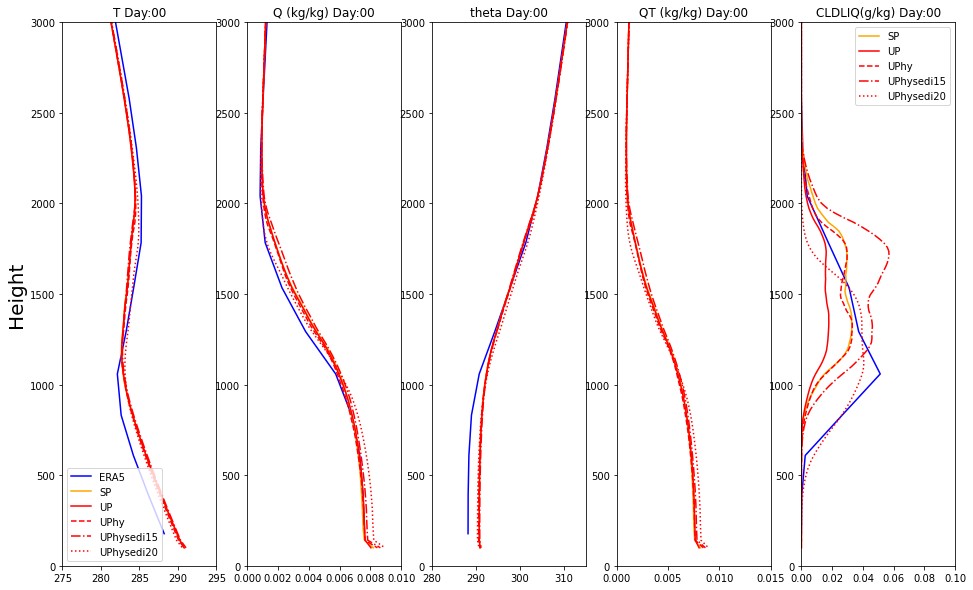

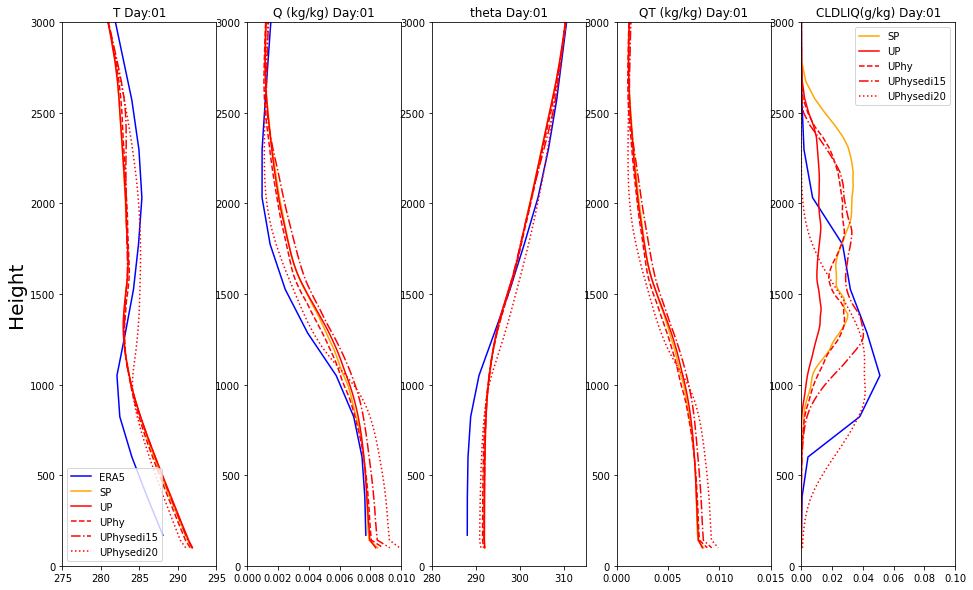

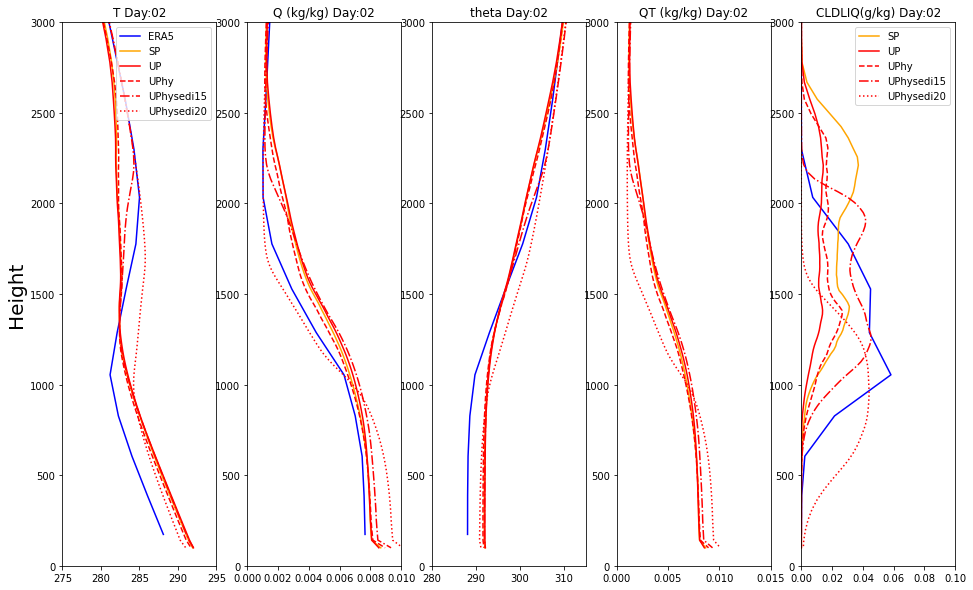

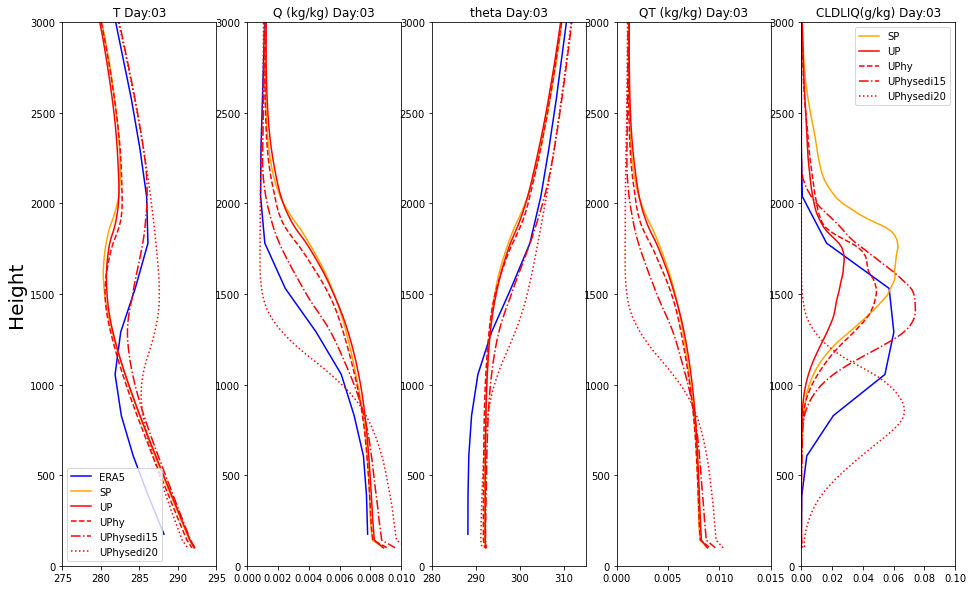

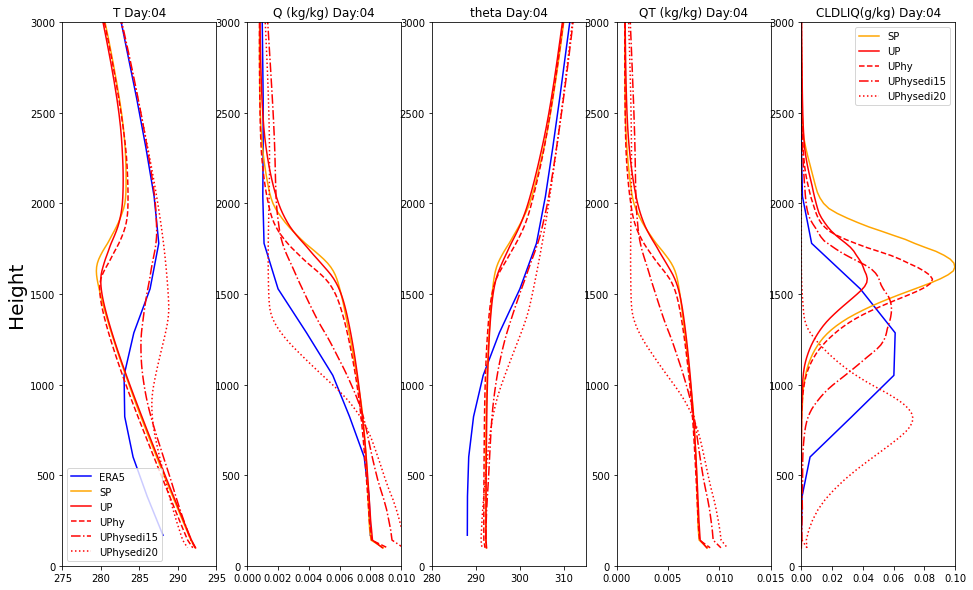

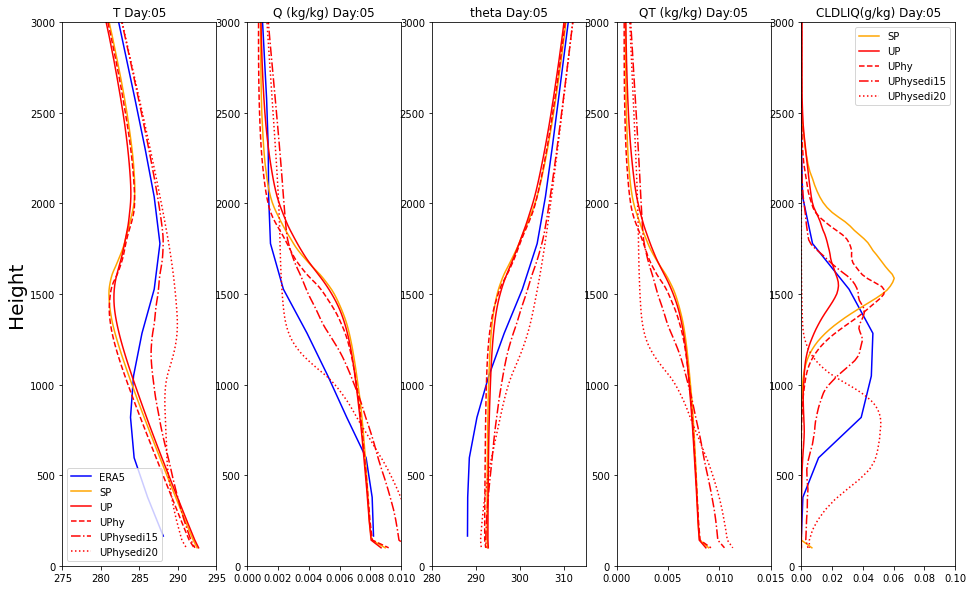

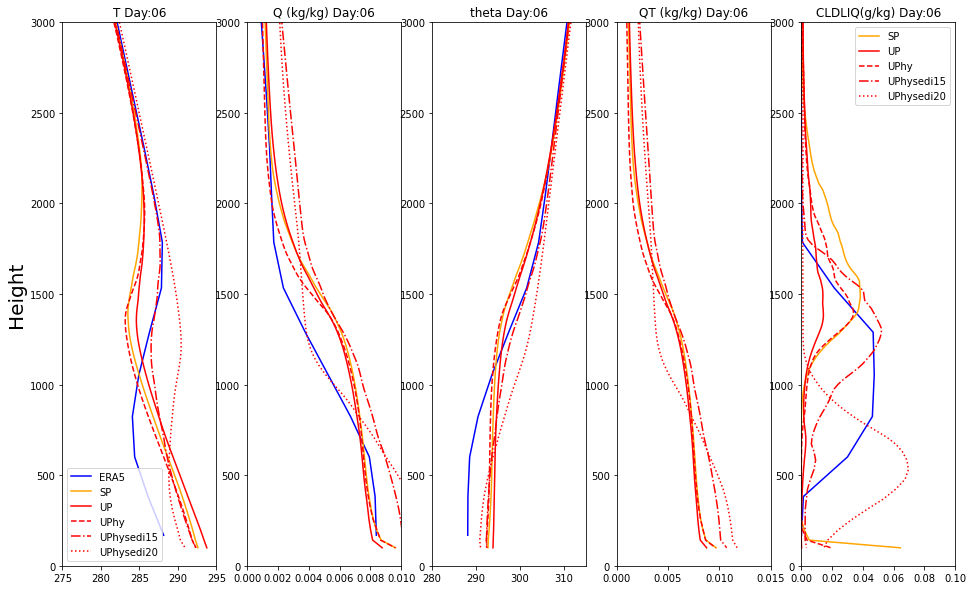

In [176]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Peruvian_dm = np.zeros([16])
    q_crossERA5Peruvian_dm = np.zeros([16])
    z_crossERA5Peruvian_dm = np.zeros([16])
    theta_crossERA5Peruvian_dm = np.zeros([16])
    lw_crossERA5Peruvian_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Peruvian_dm[:] = T_crossERA5Peruvian_dm[:] + ERA5_tPeruvian[(countday+24*iday),:]
        q_crossERA5Peruvian_dm[:] = q_crossERA5Peruvian_dm[:] + ERA5_qPeruvian[(countday+24*iday),:]
        z_crossERA5Peruvian_dm[:] = z_crossERA5Peruvian_dm[:] + ERA5_zPeruvian[(countday+24*iday),:]
        lw_crossERA5Peruvian_dm[:] = lw_crossERA5Peruvian_dm[:] + ERA5_lwPeruvian[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Peruvian_dm[izz] = potential_temperature(T_crossERA5Peruvian_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Peruvian_dm[:] = T_crossERA5Peruvian_dm[:]/(countday)
    q_crossERA5Peruvian_dm[:] = q_crossERA5Peruvian_dm[:]/(countday)
    z_crossERA5Peruvian_dm[:] = z_crossERA5Peruvian_dm[:]/(countday)
    theta_crossERA5Peruvian_dm[:] = theta_crossERA5Peruvian_dm[:]/(countday)
    lw_crossERA5Peruvian_dm[:] = lw_crossERA5Peruvian_dm[:]/(countday)
    T_crossSPPeruvian_dm = np.zeros([125])
    T_crossUPPeruvian_dm = np.zeros([125])
    T_crossUPhyPeruvian_dm = np.zeros([125])
    T_crossUPhysedi15Peruvian_dm = np.zeros([125])
    T_crossUPhysedi20Peruvian_dm = np.zeros([125])
    Q_crossSPPeruvian_dm = np.zeros([125])
    Q_crossUPPeruvian_dm = np.zeros([125])
    Q_crossUPhyPeruvian_dm = np.zeros([125])
    Q_crossUPhysedi15Peruvian_dm = np.zeros([125])
    Q_crossUPhysedi20Peruvian_dm = np.zeros([125])
    CLDICE_crossSPPeruvian_dm = np.zeros([125])
    CLDICE_crossUPPeruvian_dm = np.zeros([125])
    CLDICE_crossUPhyPeruvian_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Peruvian_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Peruvian_dm = np.zeros([125])
    CLDLIQ_crossSPPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhyPeruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Peruvian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Peruvian_dm = np.zeros([125])
    Z3_crossSPPeruvian_dm = np.zeros([125])
    Z3_crossUPPeruvian_dm = np.zeros([125])
    Z3_crossUPhyPeruvian_dm = np.zeros([125])
    Z3_crossUPhysedi15Peruvian_dm = np.zeros([125])
    Z3_crossUPhysedi20Peruvian_dm = np.zeros([125])
    theta_crossSPPeruvian_dm = np.zeros([125])
    theta_crossUPPeruvian_dm = np.zeros([125])
    theta_crossUPhyPeruvian_dm = np.zeros([125])
    theta_crossUPhysedi15Peruvian_dm = np.zeros([125])
    theta_crossUPhysedi20Peruvian_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPPeruvian_dm[:] = T_crossSPPeruvian_dm[:] + T_crossSPPeruvian[:,isec+144*iday]
        T_crossUPPeruvian_dm[:] = T_crossUPPeruvian_dm[:] + T_crossUPPeruvian[:,isec+144*iday]
        T_crossUPhyPeruvian_dm[:] = T_crossUPhyPeruvian_dm[:] + T_crossUPhyPeruvian[:,isec+144*iday]
        T_crossUPhysedi15Peruvian_dm[:] = T_crossUPhysedi15Peruvian_dm[:] + T_crossUPhysedi15Peruvian[:,isec+144*iday]
        T_crossUPhysedi20Peruvian_dm[:] = T_crossUPhysedi20Peruvian_dm[:] + T_crossUPhysedi20Peruvian[:,isec+144*iday]
        Q_crossSPPeruvian_dm[:] = Q_crossSPPeruvian_dm[:] + Q_crossSPPeruvian[:,isec+144*iday]
        Q_crossUPPeruvian_dm[:] = Q_crossUPPeruvian_dm[:] + Q_crossUPPeruvian[:,isec+144*iday]
        Q_crossUPhyPeruvian_dm[:] = Q_crossUPhyPeruvian_dm[:] + Q_crossUPhyPeruvian[:,isec+144*iday]
        Q_crossUPhysedi15Peruvian_dm[:] = Q_crossUPhysedi15Peruvian_dm[:] + Q_crossUPhysedi15Peruvian[:,isec+144*iday]
        Q_crossUPhysedi20Peruvian_dm[:] = Q_crossUPhysedi20Peruvian_dm[:] + Q_crossUPhysedi20Peruvian[:,isec+144*iday]
        CLDLIQ_crossSPPeruvian_dm[:] = CLDLIQ_crossSPPeruvian_dm[:] + CLDLIQ_crossSPPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPPeruvian_dm[:] = CLDLIQ_crossUPPeruvian_dm[:] + CLDLIQ_crossUPPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPhyPeruvian_dm[:] = CLDLIQ_crossUPhyPeruvian_dm[:] + CLDLIQ_crossUPhyPeruvian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Peruvian_dm[:] = CLDLIQ_crossUPhysedi15Peruvian_dm[:] + CLDLIQ_crossUPhysedi15Peruvian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Peruvian_dm[:] = CLDLIQ_crossUPhysedi20Peruvian_dm[:] + CLDLIQ_crossUPhysedi20Peruvian[:,isec+144*iday]
        CLDICE_crossSPPeruvian_dm[:] = CLDICE_crossSPPeruvian_dm[:] + CLDICE_crossSPPeruvian[:,isec+144*iday]
        CLDICE_crossUPPeruvian_dm[:] = CLDICE_crossUPPeruvian_dm[:] + CLDICE_crossUPPeruvian[:,isec+144*iday]
        CLDICE_crossUPhyPeruvian_dm[:] = CLDICE_crossUPhyPeruvian_dm[:] + CLDICE_crossUPhyPeruvian[:,isec+144*iday]
        CLDICE_crossUPhysedi15Peruvian_dm[:] = CLDICE_crossUPhysedi15Peruvian_dm[:] + CLDICE_crossUPhysedi15Peruvian[:,isec+144*iday]
        CLDICE_crossUPhysedi20Peruvian_dm[:] = CLDICE_crossUPhysedi20Peruvian_dm[:] + CLDICE_crossUPhysedi20Peruvian[:,isec+144*iday]
        Z3_crossSPPeruvian_dm[:] = Z3_crossSPPeruvian_dm[:] + Z3_crossSPPeruvian[:,isec+144*iday]
        Z3_crossUPPeruvian_dm[:] = Z3_crossUPPeruvian_dm[:] + Z3_crossUPPeruvian[:,isec+144*iday]
        Z3_crossUPhyPeruvian_dm[:] = Z3_crossUPhyPeruvian_dm[:] + Z3_crossUPhyPeruvian[:,isec+144*iday]
        Z3_crossUPhysedi15Peruvian_dm[:] = Z3_crossUPhysedi15Peruvian_dm[:] + Z3_crossUPhysedi15Peruvian[:,isec+144*iday]
        Z3_crossUPhysedi20Peruvian_dm[:] = Z3_crossUPhysedi20Peruvian_dm[:] + Z3_crossUPhysedi20Peruvian[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPPeruvian_dm[izz] = theta_crossSPPeruvian_dm[izz] + potential_temperature(T_crossSPPeruvian[izz,isec+144*iday],P_crossSPPeruvian[izz,isec+144*iday]*100)
            #theta_crossUPPeruvian_dm[izz] = theta_crossUPPeruvian_dm[izz] + potential_temperature(T_crossUPPeruvian[izz,isec+144*iday],P_crossUPPeruvian[izz,isec+144*iday]*100)
            #theta_crossUPhyPeruvian_dm[izz] = theta_crossUPhyPeruvian_dm[izz] + potential_temperature(T_crossUPhyPeruvian[izz,isec+144*iday],P_crossUPhyPeruvian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Peruvian_dm[izz] = theta_crossUPhysedi15Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi15Peruvian[izz,isec+144*iday],P_crossUPhysedi15Peruvian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Peruvian_dm[izz] = theta_crossUPhysedi20Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi20Peruvian[izz,isec+144*iday],P_crossUPhysedi20Peruvian[izz,isec+144*iday]*100)
            theta_crossSPPeruvian_dm[izz] = theta_crossSPPeruvian_dm[izz] + potential_temperature(T_crossSPPeruvian[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPPeruvian_dm[izz] = theta_crossUPPeruvian_dm[izz] + potential_temperature(T_crossUPPeruvian[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyPeruvian_dm[izz] = theta_crossUPhyPeruvian_dm[izz] + potential_temperature(T_crossUPhyPeruvian[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Peruvian_dm[izz] = theta_crossUPhysedi15Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi15Peruvian[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Peruvian_dm[izz] = theta_crossUPhysedi20Peruvian_dm[izz] + potential_temperature(T_crossUPhysedi20Peruvian[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPPeruvian_dm = T_crossSPPeruvian_dm/(countsec)
    T_crossUPPeruvian_dm = T_crossUPPeruvian_dm/(countsec)
    T_crossUPhyPeruvian_dm = T_crossUPhyPeruvian_dm/(countsec)
    T_crossUPhysedi15Peruvian_dm = T_crossUPhysedi15Peruvian_dm/(countsec)
    T_crossUPhysedi20Peruvian_dm = T_crossUPhysedi20Peruvian_dm/(countsec)
    Q_crossSPPeruvian_dm = Q_crossSPPeruvian_dm/(countsec)
    Q_crossUPPeruvian_dm = Q_crossUPPeruvian_dm/(countsec)
    Q_crossUPhyPeruvian_dm = Q_crossUPhyPeruvian_dm/(countsec)
    Q_crossUPhysedi15Peruvian_dm = Q_crossUPhysedi15Peruvian_dm/(countsec)
    Q_crossUPhysedi20Peruvian_dm = Q_crossUPhysedi20Peruvian_dm/(countsec)  
    CLDICE_crossSPPeruvian_dm = CLDICE_crossSPPeruvian_dm/(countsec)
    CLDICE_crossUPPeruvian_dm = CLDICE_crossUPPeruvian_dm/(countsec)
    CLDICE_crossUPhyPeruvian_dm = CLDICE_crossUPhyPeruvian_dm/(countsec)
    CLDICE_crossUPhysedi15Peruvian_dm = CLDICE_crossUPhysedi15Peruvian_dm/(countsec)
    CLDICE_crossUPhysedi20Peruvian_dm = CLDICE_crossUPhysedi20Peruvian_dm/(countsec)  
    CLDLIQ_crossSPPeruvian_dm = CLDLIQ_crossSPPeruvian_dm/(countsec)
    CLDLIQ_crossUPPeruvian_dm = CLDLIQ_crossUPPeruvian_dm/(countsec)
    CLDLIQ_crossUPhyPeruvian_dm = CLDLIQ_crossUPhyPeruvian_dm/(countsec)
    CLDLIQ_crossUPhysedi15Peruvian_dm = CLDLIQ_crossUPhysedi15Peruvian_dm/(countsec)
    CLDLIQ_crossUPhysedi20Peruvian_dm = CLDLIQ_crossUPhysedi20Peruvian_dm/(countsec)  
    Z3_crossSPPeruvian_dm = Z3_crossSPPeruvian_dm/(countsec)
    Z3_crossUPPeruvian_dm = Z3_crossUPPeruvian_dm/(countsec)
    Z3_crossUPhyPeruvian_dm = Z3_crossUPhyPeruvian_dm/(countsec)
    Z3_crossUPhysedi15Peruvian_dm = Z3_crossUPhysedi15Peruvian_dm/(countsec)
    Z3_crossUPhysedi20Peruvian_dm = Z3_crossUPhysedi20Peruvian_dm/(countsec) 
    theta_crossSPPeruvian_dm = theta_crossSPPeruvian_dm/(countsec)
    theta_crossUPPeruvian_dm = theta_crossUPPeruvian_dm/(countsec)
    theta_crossUPhyPeruvian_dm = theta_crossUPhyPeruvian_dm/(countsec)
    theta_crossUPhysedi15Peruvian_dm = theta_crossUPhysedi15Peruvian_dm/(countsec)
    theta_crossUPhysedi20Peruvian_dm = theta_crossUPhysedi20Peruvian_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.010), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPPeruvian_dm = Q_crossSPPeruvian_dm+CLDICE_crossSPPeruvian_dm+CLDLIQ_crossSPPeruvian_dm
    QT_crossUPPeruvian_dm = Q_crossUPPeruvian_dm+CLDICE_crossUPPeruvian_dm+CLDLIQ_crossUPPeruvian_dm
    QT_crossUPhyPeruvian_dm = Q_crossUPhyPeruvian_dm+CLDICE_crossUPhyPeruvian_dm+CLDLIQ_crossUPhyPeruvian_dm
    QT_crossUPhysedi15Peruvian_dm = Q_crossUPhysedi15Peruvian_dm+CLDICE_crossUPhysedi15Peruvian_dm+CLDLIQ_crossUPhysedi15Peruvian_dm
    QT_crossUPhysedi20Peruvian_dm = Q_crossUPhysedi20Peruvian_dm+CLDICE_crossUPhysedi20Peruvian_dm+CLDLIQ_crossUPhysedi20Peruvian_dm
    cf42 = ax4.plot(QT_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Peruvian_dm,z_crossERA5Peruvian_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPPeruvian_dm,Z3_crossSPPeruvian_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPPeruvian_dm,Z3_crossUPPeruvian_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyPeruvian_dm,Z3_crossUPhyPeruvian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Peruvian_dm,Z3_crossUPhysedi15Peruvian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Peruvian_dm,Z3_crossUPhysedi20Peruvian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Peruvian_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

In [175]:
lw_crossERA5Peruvian_dm

array([1.06187686e-08, 8.28248612e-10, 2.13192452e-10, 0.00000000e+00,
       1.38650563e-08, 3.62369315e-08, 6.56164566e-08, 8.98497697e-08,
       6.96616732e-07, 2.13947716e-05, 4.66717798e-05, 4.73706924e-05,
       4.61509628e-05, 2.99922585e-05, 1.34893884e-06, 7.79807553e-08])

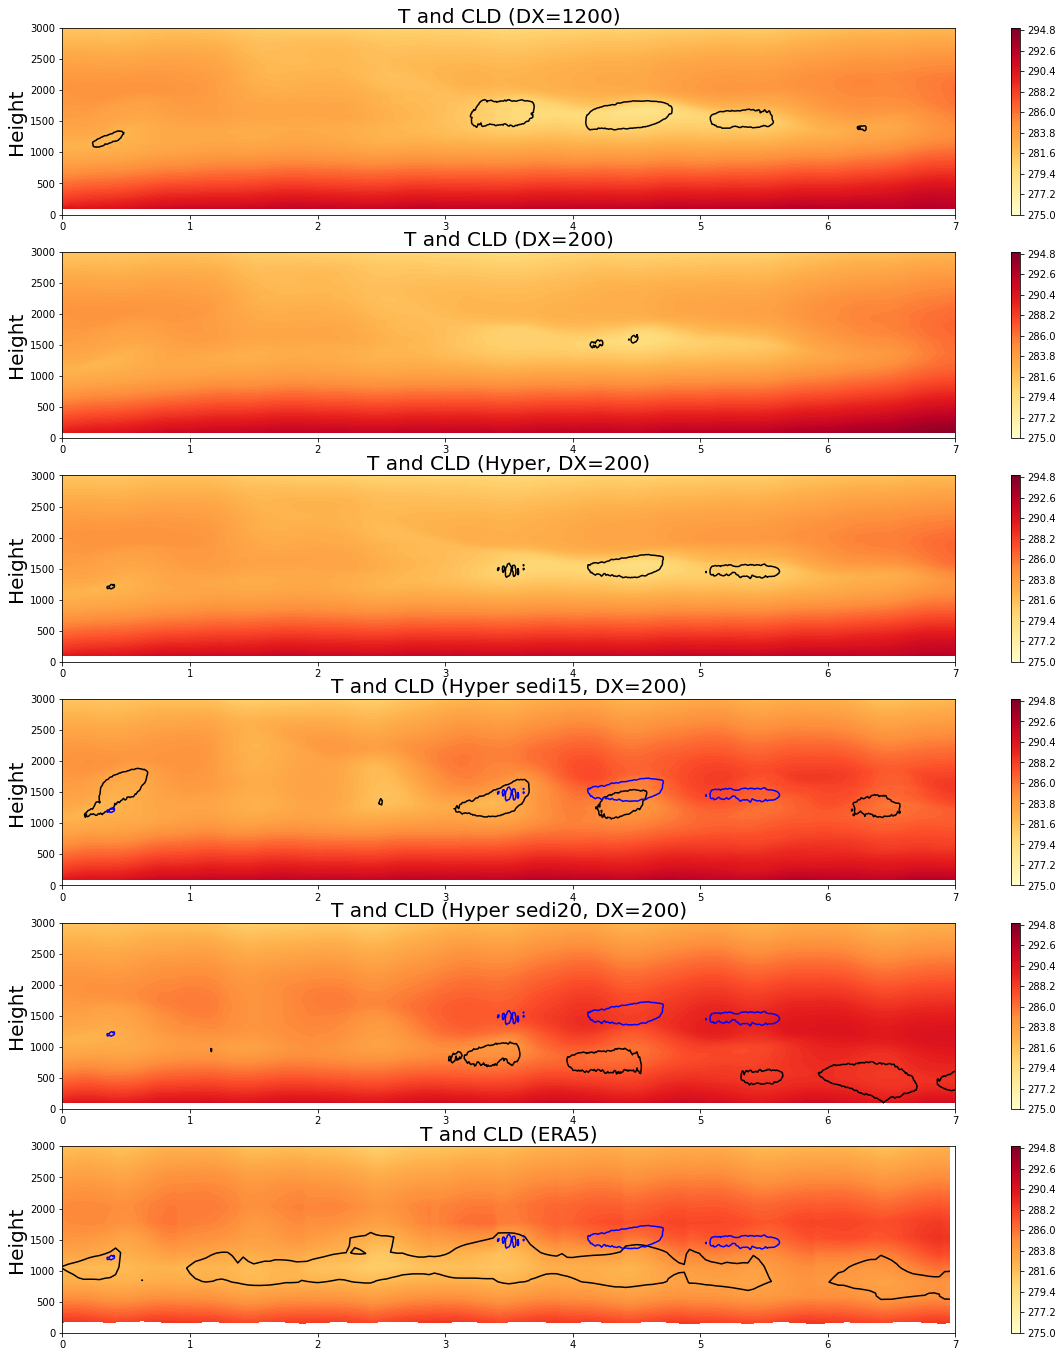

In [196]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPPeruvian,T_crossSPPeruvian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPPeruvian,cld_crossSPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPPeruvian,T_crossUPPeruvian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPPeruvian,cld_crossUPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyPeruvian,T_crossUPhyPeruvian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Peruvian,T_crossUPhysedi15Peruvian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Peruvian,cld_crossUPhysedi15Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Peruvian,T_crossUPhysedi20Peruvian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Peruvian,cld_crossUPhysedi20Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zPeruvian/9.8,ERA5_tPeruvian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zPeruvian/9.8,ERA5_ccPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Peruvian_Time_Height_Model_ERA5.png')

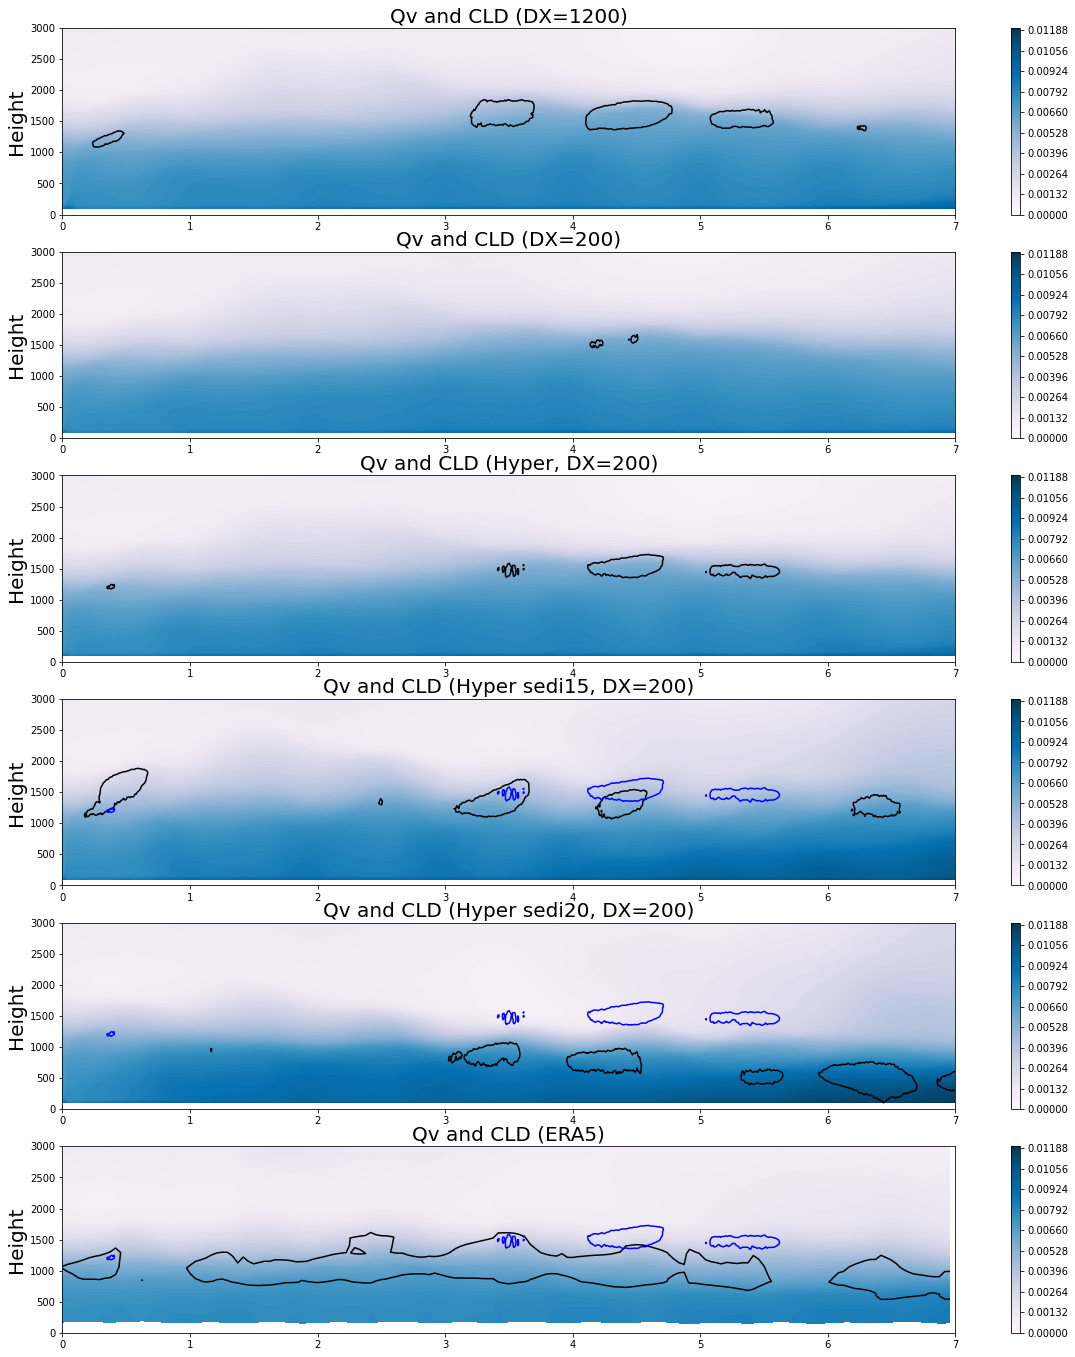

In [191]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPPeruvian,Q_crossSPPeruvian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPPeruvian,cld_crossSPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPPeruvian,Q_crossUPPeruvian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPPeruvian,cld_crossUPPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyPeruvian,Q_crossUPhyPeruvian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Peruvian,Q_crossUPhysedi15Peruvian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Peruvian,cld_crossUPhysedi15Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Peruvian,Q_crossUPhysedi20Peruvian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Peruvian,cld_crossUPhysedi20Peruvian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zPeruvian/9.8,ERA5_qPeruvian,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zPeruvian/9.8,ERA5_ccPeruvian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyPeruvian,cld_crossUPhyPeruvian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Peruvian_Time_HeighQv_Model_ERA5.png')

# Namibian

In [148]:
spww_SPNamibian = np.zeros([1009,125])
spww_UPNamibian = np.zeros([1009,125])
spww_UPhyNamibian = np.zeros([1009,125])
spww_UPhysedi20Namibian = np.zeros([1009,125])
spww_UPhysedi15Namibian = np.zeros([1009,125])
Z3_SPNamibian = np.zeros([1009,125])
Z3_UPNamibian = np.zeros([1009,125])
Z3_UPhyNamibian = np.zeros([1009,125])
Z3_UPhysedi20Namibian = np.zeros([1009,125])
Z3_UPhysedi15Namibian = np.zeros([1009,125])
pttend_SPNamibian = np.zeros([1009,125])
pttend_UPNamibian = np.zeros([1009,125])
pttend_UPhyNamibian = np.zeros([1009,125])
pttend_UPhysedi20Namibian = np.zeros([1009,125])
pttend_UPhysedi15Namibian = np.zeros([1009,125])
cld_SPNamibian = np.zeros([1009,125])
cld_UPNamibian = np.zeros([1009,125])
cld_UPhyNamibian = np.zeros([1009,125])
cld_UPhysedi20Namibian = np.zeros([1009,125])
cld_UPhysedi15Namibian = np.zeros([1009,125])
T_SPNamibian = np.zeros([1009,125])
T_UPNamibian = np.zeros([1009,125])
T_UPhyNamibian = np.zeros([1009,125])
T_UPhysedi20Namibian = np.zeros([1009,125])
T_UPhysedi15Namibian = np.zeros([1009,125])
CLDLIQ_SPNamibian = np.zeros([1009,125])
CLDLIQ_UPNamibian = np.zeros([1009,125])
CLDLIQ_UPhyNamibian = np.zeros([1009,125])
CLDLIQ_UPhysedi20Namibian = np.zeros([1009,125])
CLDLIQ_UPhysedi15Namibian = np.zeros([1009,125])
CLDICE_SPNamibian = np.zeros([1009,125])
CLDICE_UPNamibian = np.zeros([1009,125])
CLDICE_UPhyNamibian = np.zeros([1009,125])
CLDICE_UPhysedi20Namibian = np.zeros([1009,125])
CLDICE_UPhysedi15Namibian = np.zeros([1009,125])
Q_SPNamibian = np.zeros([1009,125])
Q_UPNamibian = np.zeros([1009,125])
Q_UPhyNamibian = np.zeros([1009,125])
Q_UPhysedi20Namibian = np.zeros([1009,125])
Q_UPhysedi15Namibian = np.zeros([1009,125])
P_SPNamibian = np.zeros([1009,125])
P_UPNamibian = np.zeros([1009,125])
P_UPhyNamibian = np.zeros([1009,125])
P_UPhysedi20Namibian = np.zeros([1009,125])
P_UPhysedi15Namibian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Namibian)):
        spww_SPNamibian[it,:] = spww_SPNamibian[it,:] + SPWWSP[it,:,ind_Namibian[il]]
        spww_UPNamibian[it,:] = spww_UPNamibian[it,:] + SPWWUP[it,:,ind_Namibian[il]]
        spww_UPhyNamibian[it,:] = spww_UPhyNamibian[it,:] + SPWWUPhy[it,:,ind_Namibian[il]]
        spww_UPhysedi15Namibian[it,:] = spww_UPhysedi15Namibian[it,:] + SPWWUPhysedi15[it,:,ind_Namibian[il]]
        spww_UPhysedi20Namibian[it,:] = spww_UPhysedi20Namibian[it,:] + SPWWUPhysedi20[it,:,ind_Namibian[il]]
        Z3_SPNamibian[it,:] = Z3_SPNamibian[it,:] + Z3SP[it,:,ind_Namibian[il]]
        Z3_UPNamibian[it,:] = Z3_UPNamibian[it,:] + Z3UP[it,:,ind_Namibian[il]]
        Z3_UPhyNamibian[it,:] = Z3_UPhyNamibian[it,:] + Z3UPhy[it,:,ind_Namibian[il]]
        Z3_UPhysedi15Namibian[it,:] = Z3_UPhysedi15Namibian[it,:] + Z3UPhysedi15[it,:,ind_Namibian[il]]
        Z3_UPhysedi20Namibian[it,:] = Z3_UPhysedi20Namibian[it,:] + Z3UPhysedi20[it,:,ind_Namibian[il]]
        T_SPNamibian[it,:] = T_SPNamibian[it,:] + T_SP[it,:,ind_Namibian[il]]
        T_UPNamibian[it,:] = T_UPNamibian[it,:] + T_UP[it,:,ind_Namibian[il]]
        T_UPhyNamibian[it,:] = T_UPhyNamibian[it,:] + T_UPhy[it,:,ind_Namibian[il]]
        T_UPhysedi15Namibian[it,:] = T_UPhysedi15Namibian[it,:] + T_UPhysedi15[it,:,ind_Namibian[il]]
        T_UPhysedi20Namibian[it,:] = T_UPhysedi20Namibian[it,:] + T_UPhysedi20[it,:,ind_Namibian[il]]
        CLDICE_SPNamibian[it,:] = CLDICE_SPNamibian[it,:] + CLDICE_SP[it,:,ind_Namibian[il]]
        CLDICE_UPNamibian[it,:] = CLDICE_UPNamibian[it,:] + CLDICE_UP[it,:,ind_Namibian[il]]
        CLDICE_UPhyNamibian[it,:] = CLDICE_UPhyNamibian[it,:] + CLDICE_UPhy[it,:,ind_Namibian[il]]
        CLDICE_UPhysedi15Namibian[it,:] = CLDICE_UPhysedi15Namibian[it,:] + CLDICE_UPhysedi15[it,:,ind_Namibian[il]]
        CLDICE_UPhysedi20Namibian[it,:] = CLDICE_UPhysedi20Namibian[it,:] + CLDICE_UPhysedi20[it,:,ind_Namibian[il]]
        CLDLIQ_SPNamibian[it,:] = CLDLIQ_SPNamibian[it,:] + CLDLIQ_SP[it,:,ind_Namibian[il]]
        CLDLIQ_UPNamibian[it,:] = CLDLIQ_UPNamibian[it,:] + CLDLIQ_UP[it,:,ind_Namibian[il]]
        CLDLIQ_UPhyNamibian[it,:] = CLDLIQ_UPhyNamibian[it,:] + CLDLIQ_UPhy[it,:,ind_Namibian[il]]
        CLDLIQ_UPhysedi15Namibian[it,:] = CLDLIQ_UPhysedi15Namibian[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Namibian[il]]
        CLDLIQ_UPhysedi20Namibian[it,:] = CLDLIQ_UPhysedi20Namibian[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Namibian[il]]
        Q_SPNamibian[it,:] = Q_SPNamibian[it,:] + Q_SP[it,:,ind_Namibian[il]]
        Q_UPNamibian[it,:] = Q_UPNamibian[it,:] + Q_UP[it,:,ind_Namibian[il]]
        Q_UPhyNamibian[it,:] = Q_UPhyNamibian[it,:] + Q_UPhy[it,:,ind_Namibian[il]]
        Q_UPhysedi15Namibian[it,:] = Q_UPhysedi15Namibian[it,:] + Q_UPhysedi15[it,:,ind_Namibian[il]]
        Q_UPhysedi20Namibian[it,:] = Q_UPhysedi20Namibian[it,:] + Q_UPhysedi20[it,:,ind_Namibian[il]]
        pttend_SPNamibian[it,:] = pttend_SPNamibian[it,:] + PTTEND_SP[it,:,ind_Namibian[il]]
        pttend_UPNamibian[it,:] = pttend_UPNamibian[it,:] + PTTEND_UP[it,:,ind_Namibian[il]]
        pttend_UPhyNamibian[it,:] = pttend_UPhyNamibian[it,:] + PTTEND_UPhy[it,:,ind_Namibian[il]]
        pttend_UPhysedi15Namibian[it,:] = pttend_UPhysedi15Namibian[it,:] + PTTEND_UPhysedi15[it,:,ind_Namibian[il]]
        pttend_UPhysedi20Namibian[it,:] = pttend_UPhysedi20Namibian[it,:] + PTTEND_UPhysedi20[it,:,ind_Namibian[il]]
        cld_SPNamibian[it,:] = cld_SPNamibian[it,:] + CLOUD_SP[it,:,ind_Namibian[il]]
        cld_UPNamibian[it,:] = cld_UPNamibian[it,:] + CLOUD_UP[it,:,ind_Namibian[il]]
        cld_UPhyNamibian[it,:] = cld_UPhyNamibian[it,:] + CLOUD_UPhy[it,:,ind_Namibian[il]]
        cld_UPhysedi15Namibian[it,:] = cld_UPhysedi15Namibian[it,:] + CLOUD_UPhysedi15[it,:,ind_Namibian[il]]
        cld_UPhysedi20Namibian[it,:] = cld_UPhysedi20Namibian[it,:] + CLOUD_UPhysedi20[it,:,ind_Namibian[il]]
        P_SPNamibian[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPNamibian[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyNamibian[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Namibian[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Namibian[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPNamibian[it,:] = spww_SPNamibian[it,:] /count
    spww_UPNamibian[it,:] = spww_UPNamibian[it,:]  /count
    spww_UPhyNamibian[it,:] = spww_UPhyNamibian[it,:] /count
    spww_UPhysedi15Namibian[it,:] = spww_UPhysedi15Namibian[it,:] /count
    spww_UPhysedi20Namibian[it,:] = spww_UPhysedi20Namibian[it,:] /count
    Z3_SPNamibian[it,:] = Z3_SPNamibian[it,:] /count
    Z3_UPNamibian[it,:] = Z3_UPNamibian[it,:]  /count
    Z3_UPhyNamibian[it,:] = Z3_UPhyNamibian[it,:] /count
    Z3_UPhysedi15Namibian[it,:] = Z3_UPhysedi15Namibian[it,:] /count
    Z3_UPhysedi20Namibian[it,:] = Z3_UPhysedi20Namibian[it,:] /count
    T_SPNamibian[it,:] = T_SPNamibian[it,:] /count
    T_UPNamibian[it,:] = T_UPNamibian[it,:]  /count
    T_UPhyNamibian[it,:] = T_UPhyNamibian[it,:] /count
    T_UPhysedi15Namibian[it,:] = T_UPhysedi15Namibian[it,:] /count
    T_UPhysedi20Namibian[it,:] = T_UPhysedi20Namibian[it,:] /count
    CLDICE_SPNamibian[it,:] = CLDICE_SPNamibian[it,:] /count
    CLDICE_UPNamibian[it,:] = CLDICE_UPNamibian[it,:]  /count
    CLDICE_UPhyNamibian[it,:] = CLDICE_UPhyNamibian[it,:] /count
    CLDICE_UPhysedi15Namibian[it,:] = CLDICE_UPhysedi15Namibian[it,:] /count
    CLDICE_UPhysedi20Namibian[it,:] = CLDICE_UPhysedi20Namibian[it,:] /count
    CLDLIQ_SPNamibian[it,:] = CLDLIQ_SPNamibian[it,:] /count
    CLDLIQ_UPNamibian[it,:] = CLDLIQ_UPNamibian[it,:]  /count
    CLDLIQ_UPhyNamibian[it,:] = CLDLIQ_UPhyNamibian[it,:] /count
    CLDLIQ_UPhysedi15Namibian[it,:] = CLDLIQ_UPhysedi15Namibian[it,:] /count
    CLDLIQ_UPhysedi20Namibian[it,:] = CLDLIQ_UPhysedi20Namibian[it,:] /count
    Q_SPNamibian[it,:] = Q_SPNamibian[it,:] /count
    Q_UPNamibian[it,:] = Q_UPNamibian[it,:]  /count
    Q_UPhyNamibian[it,:] = Q_UPhyNamibian[it,:] /count
    Q_UPhysedi15Namibian[it,:] = Q_UPhysedi15Namibian[it,:] /count
    Q_UPhysedi20Namibian[it,:] = Q_UPhysedi20Namibian[it,:] /count
    pttend_SPNamibian[it,:] = pttend_SPNamibian[it,:] /count
    pttend_UPNamibian[it,:] = pttend_UPNamibian[it,:]  /count
    pttend_UPhyNamibian[it,:] = pttend_UPhyNamibian[it,:] /count
    pttend_UPhysedi15Namibian[it,:] = pttend_UPhysedi15Namibian[it,:] /count
    pttend_UPhysedi20Namibian[it,:] = pttend_UPhysedi20Namibian[it,:] /count
    cld_SPNamibian[it,:] = cld_SPNamibian[it,:] /count
    cld_UPNamibian[it,:] = cld_UPNamibian[it,:]  /count
    cld_UPhyNamibian[it,:] = cld_UPhyNamibian[it,:] /count
    cld_UPhysedi15Namibian[it,:] = cld_UPhysedi15Namibian[it,:] /count
    cld_UPhysedi20Namibian[it,:] = cld_UPhysedi20Namibian[it,:] /count
    P_SPNamibian[it,:] = P_SPNamibian[it,:] /count
    P_UPNamibian[it,:] = P_UPNamibian[it,:]  /count
    P_UPhyNamibian[it,:] = P_UPhyNamibian[it,:] /count
    P_UPhysedi15Namibian[it,:] = P_UPhysedi15Namibian[it,:] /count
    P_UPhysedi20Namibian[it,:] = P_UPhysedi20Namibian[it,:] /count
    
spww_crossSPNamibian = np.transpose(spww_SPNamibian)
spww_crossUPNamibian = np.transpose(spww_UPNamibian)
spww_crossUPhyNamibian = np.transpose(spww_UPhyNamibian)
spww_crossUPhysedi15Namibian = np.transpose(spww_UPhysedi15Namibian)
spww_crossUPhysedi20Namibian = np.transpose(spww_UPhysedi20Namibian)
Z3_crossSPNamibian = np.transpose(Z3_SPNamibian)
Z3_crossUPNamibian = np.transpose(Z3_UPNamibian)
Z3_crossUPhyNamibian = np.transpose(Z3_UPhyNamibian)
Z3_crossUPhysedi15Namibian = np.transpose(Z3_UPhysedi15Namibian)
Z3_crossUPhysedi20Namibian = np.transpose(Z3_UPhysedi20Namibian)
T_crossSPNamibian = np.transpose(T_SPNamibian)
T_crossUPNamibian = np.transpose(T_UPNamibian)
T_crossUPhyNamibian = np.transpose(T_UPhyNamibian)
T_crossUPhysedi15Namibian = np.transpose(T_UPhysedi15Namibian)
T_crossUPhysedi20Namibian = np.transpose(T_UPhysedi20Namibian)
CLDICE_crossSPNamibian = np.transpose(CLDICE_SPNamibian)
CLDICE_crossUPNamibian = np.transpose(CLDICE_UPNamibian)
CLDICE_crossUPhyNamibian = np.transpose(CLDICE_UPhyNamibian)
CLDICE_crossUPhysedi15Namibian = np.transpose(CLDICE_UPhysedi15Namibian)
CLDICE_crossUPhysedi20Namibian = np.transpose(CLDICE_UPhysedi20Namibian)
CLDLIQ_crossSPNamibian = np.transpose(CLDLIQ_SPNamibian)
CLDLIQ_crossUPNamibian = np.transpose(CLDLIQ_UPNamibian)
CLDLIQ_crossUPhyNamibian = np.transpose(CLDLIQ_UPhyNamibian)
CLDLIQ_crossUPhysedi15Namibian = np.transpose(CLDLIQ_UPhysedi15Namibian)
CLDLIQ_crossUPhysedi20Namibian = np.transpose(CLDLIQ_UPhysedi20Namibian)
Q_crossSPNamibian = np.transpose(Q_SPNamibian)
Q_crossUPNamibian = np.transpose(Q_UPNamibian)
Q_crossUPhyNamibian = np.transpose(Q_UPhyNamibian)
Q_crossUPhysedi15Namibian = np.transpose(Q_UPhysedi15Namibian)
Q_crossUPhysedi20Namibian = np.transpose(Q_UPhysedi20Namibian)
pttend_crossSPNamibian = np.transpose(pttend_SPNamibian)
pttend_crossUPNamibian = np.transpose(pttend_UPNamibian)
pttend_crossUPhyNamibian = np.transpose(pttend_UPhyNamibian)
pttend_crossUPhysedi15Namibian = np.transpose(pttend_UPhysedi15Namibian)
pttend_crossUPhysedi20Namibian = np.transpose(pttend_UPhysedi20Namibian)
cld_crossSPNamibian = np.transpose(cld_SPNamibian)
cld_crossUPNamibian = np.transpose(cld_UPNamibian)
cld_crossUPhyNamibian = np.transpose(cld_UPhyNamibian)
cld_crossUPhysedi15Namibian = np.transpose(cld_UPhysedi15Namibian)
cld_crossUPhysedi20Namibian = np.transpose(cld_UPhysedi20Namibian)
P_crossSPNamibian = np.transpose(P_SPNamibian)
P_crossUPNamibian = np.transpose(P_UPNamibian)
P_crossUPhyNamibian = np.transpose(P_UPhyNamibian)
P_crossUPhysedi15Namibian = np.transpose(P_UPhysedi15Namibian)
P_crossUPhysedi20Namibian = np.transpose(P_UPhysedi20Namibian)

In [177]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tNamibian = np.zeros([24*7,16])
ERA5_qNamibian = np.zeros([24*7,16])
ERA5_zNamibian = np.zeros([24*7,16])
ERA5_ccNamibian = np.zeros([24*7,16])
ERA5_lwNamibian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Namibian_ERA5)):
                ERA5_tNamibian[countt,iz] = ERA5_tNamibian[countt,iz] + temp1d[ind_Namibian_ERA5[il]]
                ERA5_zNamibian[countt,iz] = ERA5_zNamibian[countt,iz] + temp1d2[ind_Namibian_ERA5[il]]
                ERA5_ccNamibian[countt,iz] = ERA5_ccNamibian[countt,iz] + temp1d3[ind_Namibian_ERA5[il]]
                ERA5_qNamibian[countt,iz] = ERA5_qNamibian[countt,iz] + temp1d4[ind_Namibian_ERA5[il]]
                ERA5_lwNamibian[countt,iz] = ERA5_lwNamibian[countt,iz] + temp1d5[ind_Namibian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tNamibian[countt,iz] = ERA5_tNamibian[countt,iz]/(counttt3+1)
            ERA5_zNamibian[countt,iz] = ERA5_zNamibian[countt,iz]/(counttt3+1)
            ERA5_ccNamibian[countt,iz] = ERA5_ccNamibian[countt,iz]/(counttt3+1)
            ERA5_qNamibian[countt,iz] = ERA5_qNamibian[countt,iz]/(counttt3+1)
            ERA5_lwNamibian[countt,iz] = ERA5_lwNamibian[countt,iz]/(counttt3+1)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


In [ ]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [280]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPNamibian,T_crossSPNamibian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPNamibian,cld_crossSPNamibian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPNamibian,T_crossUPNamibian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPNamibian,cld_crossUPNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyNamibian,T_crossUPhyNamibian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Namibian,T_crossUPhysedi15Namibian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Namibian,cld_crossUPhysedi15Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Namibian,T_crossUPhysedi20Namibian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Namibian,cld_crossUPhysedi20Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zNamibian/9.8,ERA5_tNamibian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zNamibian/9.8,ERA5_ccNamibian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Namibian_Time_Height_Model_ERA5.png')

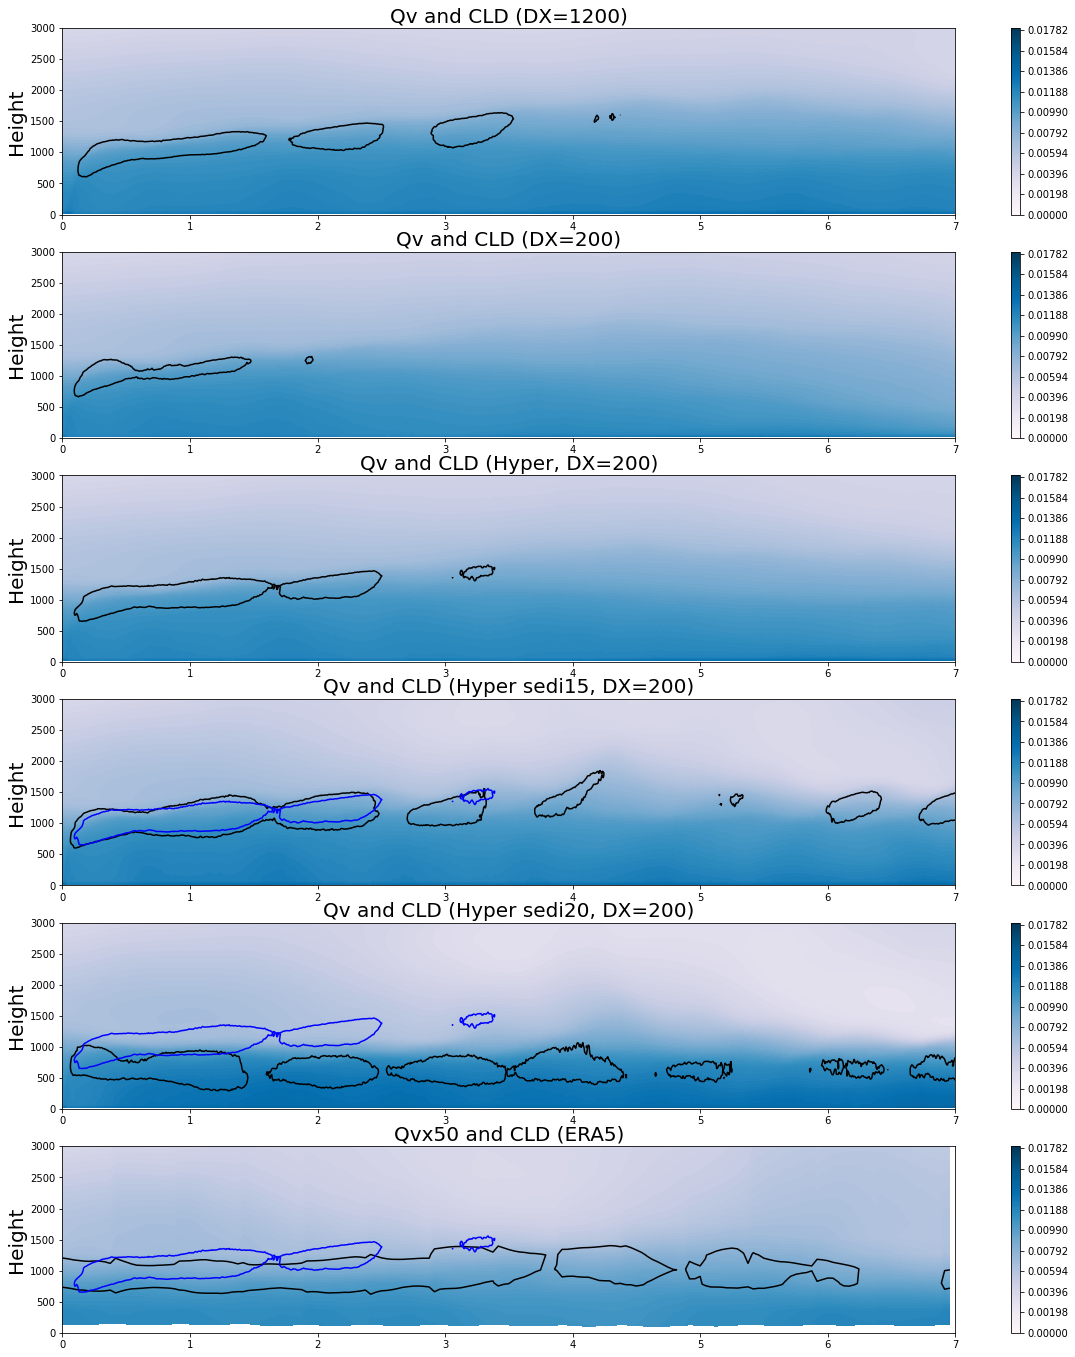

In [195]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.018]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPNamibian,Q_crossSPNamibian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPNamibian,cld_crossSPNamibian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPNamibian,Q_crossUPNamibian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPNamibian,cld_crossUPNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyNamibian,Q_crossUPhyNamibian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Namibian,Q_crossUPhysedi15Namibian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Namibian,cld_crossUPhysedi15Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Namibian,Q_crossUPhysedi20Namibian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Namibian,cld_crossUPhysedi20Namibian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zNamibian/9.8,ERA5_qNamibian,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zNamibian/9.8,ERA5_ccNamibian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyNamibian,cld_crossUPhyNamibian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qvx50 and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Namibian_Time_HeighQv_Model_ERA5.png')

0
24
1
24
2
24
3
24
4
24
5
24
6
24


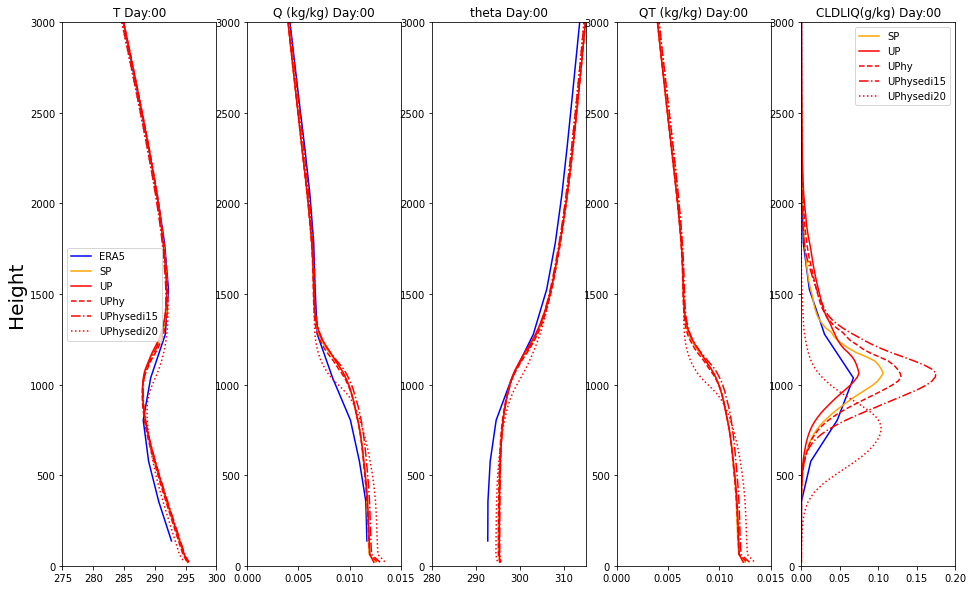

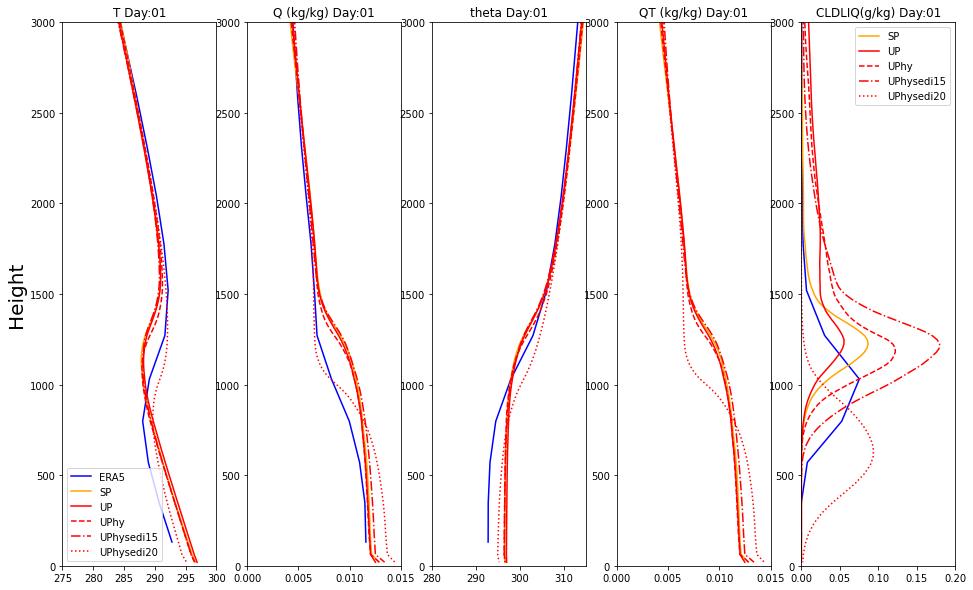

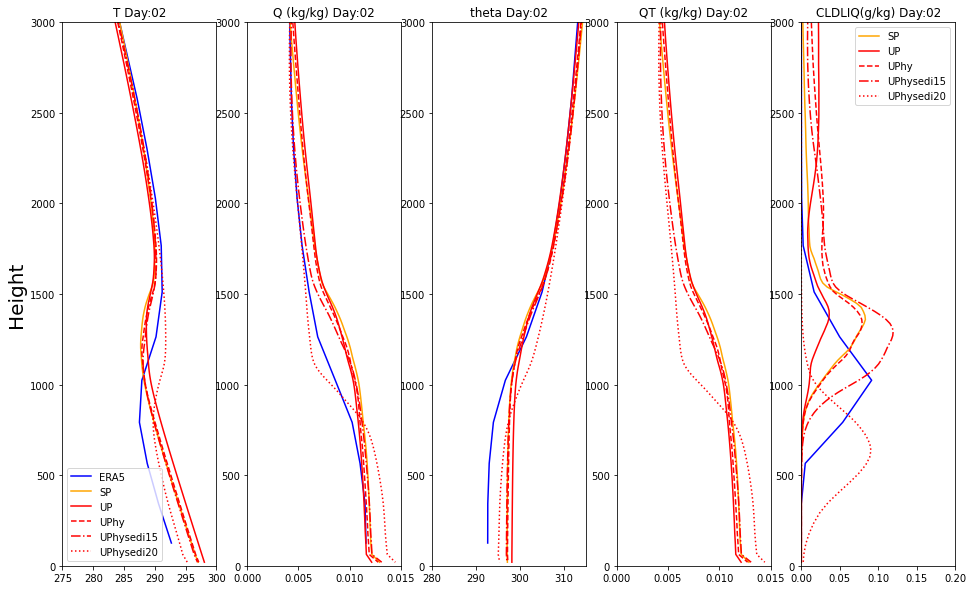

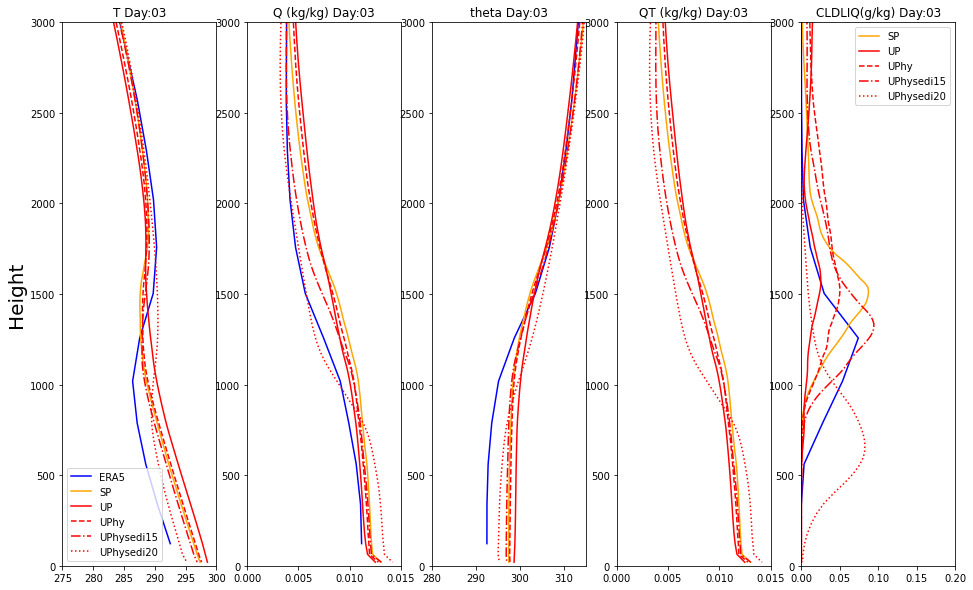

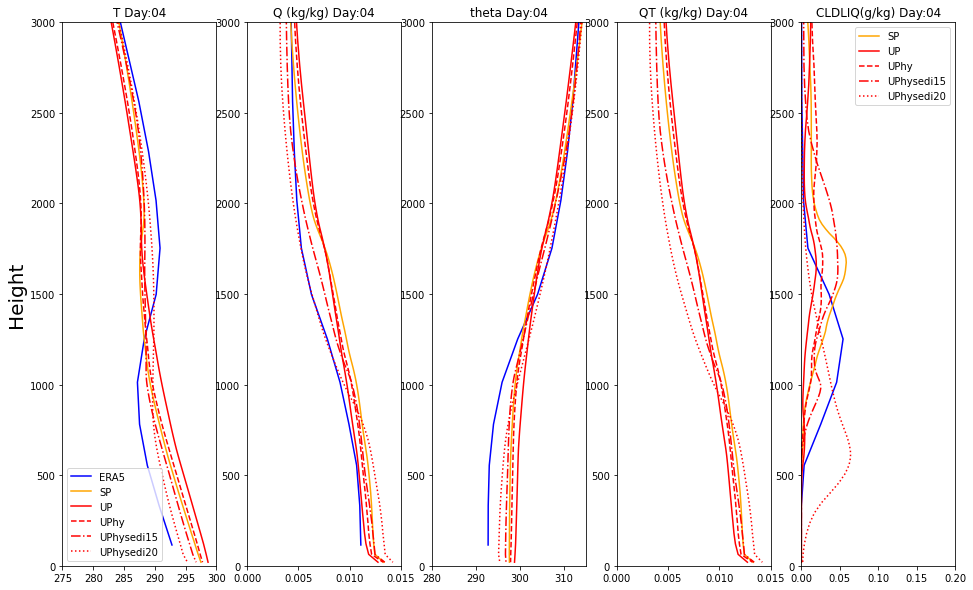

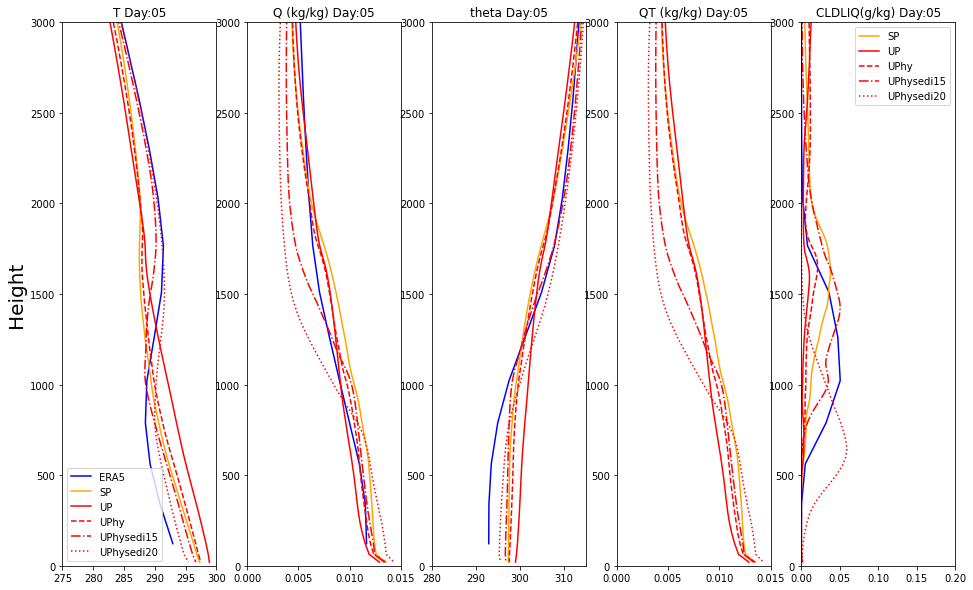

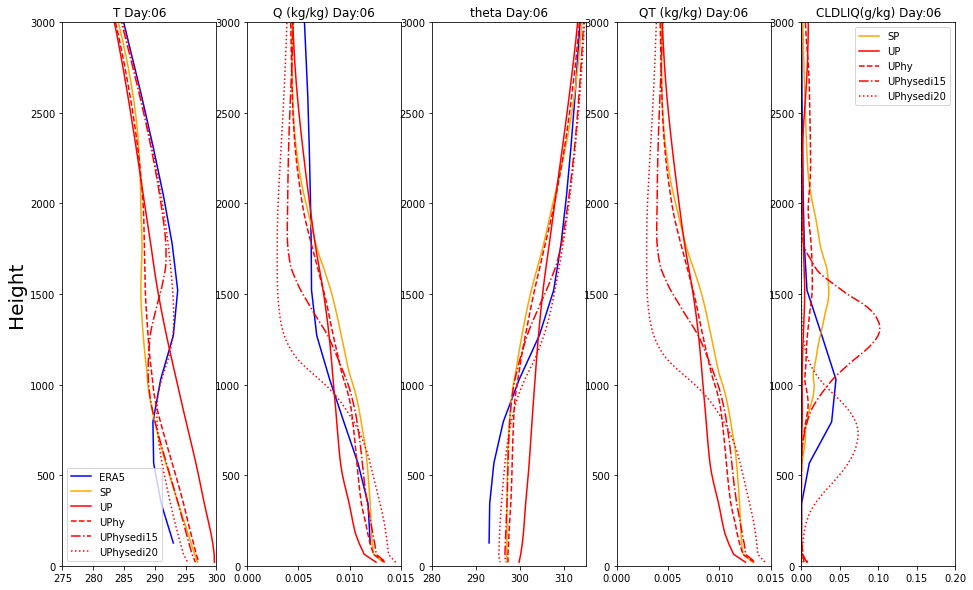

In [186]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Namibian_dm = np.zeros([16])
    q_crossERA5Namibian_dm = np.zeros([16])
    z_crossERA5Namibian_dm = np.zeros([16])
    theta_crossERA5Namibian_dm = np.zeros([16])
    lw_crossERA5Namibian_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Namibian_dm[:] = T_crossERA5Namibian_dm[:] + ERA5_tNamibian[(countday+24*iday),:]
        q_crossERA5Namibian_dm[:] = q_crossERA5Namibian_dm[:] + ERA5_qNamibian[(countday+24*iday),:]
        z_crossERA5Namibian_dm[:] = z_crossERA5Namibian_dm[:] + ERA5_zNamibian[(countday+24*iday),:]
        lw_crossERA5Namibian_dm[:] = lw_crossERA5Namibian_dm[:] + ERA5_lwNamibian[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Namibian_dm[izz] = potential_temperature(T_crossERA5Namibian_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Namibian_dm[:] = T_crossERA5Namibian_dm[:]/(countday)
    q_crossERA5Namibian_dm[:] = q_crossERA5Namibian_dm[:]/(countday)
    z_crossERA5Namibian_dm[:] = z_crossERA5Namibian_dm[:]/(countday)
    theta_crossERA5Namibian_dm[:] = theta_crossERA5Namibian_dm[:]/(countday)
    lw_crossERA5Namibian_dm[:] = lw_crossERA5Namibian_dm[:]/(countday)
    T_crossSPNamibian_dm = np.zeros([125])
    T_crossUPNamibian_dm = np.zeros([125])
    T_crossUPhyNamibian_dm = np.zeros([125])
    T_crossUPhysedi15Namibian_dm = np.zeros([125])
    T_crossUPhysedi20Namibian_dm = np.zeros([125])
    Q_crossSPNamibian_dm = np.zeros([125])
    Q_crossUPNamibian_dm = np.zeros([125])
    Q_crossUPhyNamibian_dm = np.zeros([125])
    Q_crossUPhysedi15Namibian_dm = np.zeros([125])
    Q_crossUPhysedi20Namibian_dm = np.zeros([125])
    CLDICE_crossSPNamibian_dm = np.zeros([125])
    CLDICE_crossUPNamibian_dm = np.zeros([125])
    CLDICE_crossUPhyNamibian_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Namibian_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Namibian_dm = np.zeros([125])
    CLDLIQ_crossSPNamibian_dm = np.zeros([125])
    CLDLIQ_crossUPNamibian_dm = np.zeros([125])
    CLDLIQ_crossUPhyNamibian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Namibian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Namibian_dm = np.zeros([125])
    Z3_crossSPNamibian_dm = np.zeros([125])
    Z3_crossUPNamibian_dm = np.zeros([125])
    Z3_crossUPhyNamibian_dm = np.zeros([125])
    Z3_crossUPhysedi15Namibian_dm = np.zeros([125])
    Z3_crossUPhysedi20Namibian_dm = np.zeros([125])
    theta_crossSPNamibian_dm = np.zeros([125])
    theta_crossUPNamibian_dm = np.zeros([125])
    theta_crossUPhyNamibian_dm = np.zeros([125])
    theta_crossUPhysedi15Namibian_dm = np.zeros([125])
    theta_crossUPhysedi20Namibian_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPNamibian_dm[:] = T_crossSPNamibian_dm[:] + T_crossSPNamibian[:,isec+144*iday]
        T_crossUPNamibian_dm[:] = T_crossUPNamibian_dm[:] + T_crossUPNamibian[:,isec+144*iday]
        T_crossUPhyNamibian_dm[:] = T_crossUPhyNamibian_dm[:] + T_crossUPhyNamibian[:,isec+144*iday]
        T_crossUPhysedi15Namibian_dm[:] = T_crossUPhysedi15Namibian_dm[:] + T_crossUPhysedi15Namibian[:,isec+144*iday]
        T_crossUPhysedi20Namibian_dm[:] = T_crossUPhysedi20Namibian_dm[:] + T_crossUPhysedi20Namibian[:,isec+144*iday]
        Q_crossSPNamibian_dm[:] = Q_crossSPNamibian_dm[:] + Q_crossSPNamibian[:,isec+144*iday]
        Q_crossUPNamibian_dm[:] = Q_crossUPNamibian_dm[:] + Q_crossUPNamibian[:,isec+144*iday]
        Q_crossUPhyNamibian_dm[:] = Q_crossUPhyNamibian_dm[:] + Q_crossUPhyNamibian[:,isec+144*iday]
        Q_crossUPhysedi15Namibian_dm[:] = Q_crossUPhysedi15Namibian_dm[:] + Q_crossUPhysedi15Namibian[:,isec+144*iday]
        Q_crossUPhysedi20Namibian_dm[:] = Q_crossUPhysedi20Namibian_dm[:] + Q_crossUPhysedi20Namibian[:,isec+144*iday]
        CLDLIQ_crossSPNamibian_dm[:] = CLDLIQ_crossSPNamibian_dm[:] + CLDLIQ_crossSPNamibian[:,isec+144*iday]
        CLDLIQ_crossUPNamibian_dm[:] = CLDLIQ_crossUPNamibian_dm[:] + CLDLIQ_crossUPNamibian[:,isec+144*iday]
        CLDLIQ_crossUPhyNamibian_dm[:] = CLDLIQ_crossUPhyNamibian_dm[:] + CLDLIQ_crossUPhyNamibian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Namibian_dm[:] = CLDLIQ_crossUPhysedi15Namibian_dm[:] + CLDLIQ_crossUPhysedi15Namibian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Namibian_dm[:] = CLDLIQ_crossUPhysedi20Namibian_dm[:] + CLDLIQ_crossUPhysedi20Namibian[:,isec+144*iday]
        CLDICE_crossSPNamibian_dm[:] = CLDICE_crossSPNamibian_dm[:] + CLDICE_crossSPNamibian[:,isec+144*iday]
        CLDICE_crossUPNamibian_dm[:] = CLDICE_crossUPNamibian_dm[:] + CLDICE_crossUPNamibian[:,isec+144*iday]
        CLDICE_crossUPhyNamibian_dm[:] = CLDICE_crossUPhyNamibian_dm[:] + CLDICE_crossUPhyNamibian[:,isec+144*iday]
        CLDICE_crossUPhysedi15Namibian_dm[:] = CLDICE_crossUPhysedi15Namibian_dm[:] + CLDICE_crossUPhysedi15Namibian[:,isec+144*iday]
        CLDICE_crossUPhysedi20Namibian_dm[:] = CLDICE_crossUPhysedi20Namibian_dm[:] + CLDICE_crossUPhysedi20Namibian[:,isec+144*iday]
        Z3_crossSPNamibian_dm[:] = Z3_crossSPNamibian_dm[:] + Z3_crossSPNamibian[:,isec+144*iday]
        Z3_crossUPNamibian_dm[:] = Z3_crossUPNamibian_dm[:] + Z3_crossUPNamibian[:,isec+144*iday]
        Z3_crossUPhyNamibian_dm[:] = Z3_crossUPhyNamibian_dm[:] + Z3_crossUPhyNamibian[:,isec+144*iday]
        Z3_crossUPhysedi15Namibian_dm[:] = Z3_crossUPhysedi15Namibian_dm[:] + Z3_crossUPhysedi15Namibian[:,isec+144*iday]
        Z3_crossUPhysedi20Namibian_dm[:] = Z3_crossUPhysedi20Namibian_dm[:] + Z3_crossUPhysedi20Namibian[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPNamibian_dm[izz] = theta_crossSPNamibian_dm[izz] + potential_temperature(T_crossSPNamibian[izz,isec+144*iday],P_crossSPNamibian[izz,isec+144*iday]*100)
            #theta_crossUPNamibian_dm[izz] = theta_crossUPNamibian_dm[izz] + potential_temperature(T_crossUPNamibian[izz,isec+144*iday],P_crossUPNamibian[izz,isec+144*iday]*100)
            #theta_crossUPhyNamibian_dm[izz] = theta_crossUPhyNamibian_dm[izz] + potential_temperature(T_crossUPhyNamibian[izz,isec+144*iday],P_crossUPhyNamibian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Namibian_dm[izz] = theta_crossUPhysedi15Namibian_dm[izz] + potential_temperature(T_crossUPhysedi15Namibian[izz,isec+144*iday],P_crossUPhysedi15Namibian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Namibian_dm[izz] = theta_crossUPhysedi20Namibian_dm[izz] + potential_temperature(T_crossUPhysedi20Namibian[izz,isec+144*iday],P_crossUPhysedi20Namibian[izz,isec+144*iday]*100)
            theta_crossSPNamibian_dm[izz] = theta_crossSPNamibian_dm[izz] + potential_temperature(T_crossSPNamibian[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPNamibian_dm[izz] = theta_crossUPNamibian_dm[izz] + potential_temperature(T_crossUPNamibian[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyNamibian_dm[izz] = theta_crossUPhyNamibian_dm[izz] + potential_temperature(T_crossUPhyNamibian[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Namibian_dm[izz] = theta_crossUPhysedi15Namibian_dm[izz] + potential_temperature(T_crossUPhysedi15Namibian[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Namibian_dm[izz] = theta_crossUPhysedi20Namibian_dm[izz] + potential_temperature(T_crossUPhysedi20Namibian[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPNamibian_dm = T_crossSPNamibian_dm/(countsec)
    T_crossUPNamibian_dm = T_crossUPNamibian_dm/(countsec)
    T_crossUPhyNamibian_dm = T_crossUPhyNamibian_dm/(countsec)
    T_crossUPhysedi15Namibian_dm = T_crossUPhysedi15Namibian_dm/(countsec)
    T_crossUPhysedi20Namibian_dm = T_crossUPhysedi20Namibian_dm/(countsec)
    Q_crossSPNamibian_dm = Q_crossSPNamibian_dm/(countsec)
    Q_crossUPNamibian_dm = Q_crossUPNamibian_dm/(countsec)
    Q_crossUPhyNamibian_dm = Q_crossUPhyNamibian_dm/(countsec)
    Q_crossUPhysedi15Namibian_dm = Q_crossUPhysedi15Namibian_dm/(countsec)
    Q_crossUPhysedi20Namibian_dm = Q_crossUPhysedi20Namibian_dm/(countsec)  
    CLDICE_crossSPNamibian_dm = CLDICE_crossSPNamibian_dm/(countsec)
    CLDICE_crossUPNamibian_dm = CLDICE_crossUPNamibian_dm/(countsec)
    CLDICE_crossUPhyNamibian_dm = CLDICE_crossUPhyNamibian_dm/(countsec)
    CLDICE_crossUPhysedi15Namibian_dm = CLDICE_crossUPhysedi15Namibian_dm/(countsec)
    CLDICE_crossUPhysedi20Namibian_dm = CLDICE_crossUPhysedi20Namibian_dm/(countsec)  
    CLDLIQ_crossSPNamibian_dm = CLDLIQ_crossSPNamibian_dm/(countsec)
    CLDLIQ_crossUPNamibian_dm = CLDLIQ_crossUPNamibian_dm/(countsec)
    CLDLIQ_crossUPhyNamibian_dm = CLDLIQ_crossUPhyNamibian_dm/(countsec)
    CLDLIQ_crossUPhysedi15Namibian_dm = CLDLIQ_crossUPhysedi15Namibian_dm/(countsec)
    CLDLIQ_crossUPhysedi20Namibian_dm = CLDLIQ_crossUPhysedi20Namibian_dm/(countsec)  
    Z3_crossSPNamibian_dm = Z3_crossSPNamibian_dm/(countsec)
    Z3_crossUPNamibian_dm = Z3_crossUPNamibian_dm/(countsec)
    Z3_crossUPhyNamibian_dm = Z3_crossUPhyNamibian_dm/(countsec)
    Z3_crossUPhysedi15Namibian_dm = Z3_crossUPhysedi15Namibian_dm/(countsec)
    Z3_crossUPhysedi20Namibian_dm = Z3_crossUPhysedi20Namibian_dm/(countsec) 
    theta_crossSPNamibian_dm = theta_crossSPNamibian_dm/(countsec)
    theta_crossUPNamibian_dm = theta_crossUPNamibian_dm/(countsec)
    theta_crossUPhyNamibian_dm = theta_crossUPhyNamibian_dm/(countsec)
    theta_crossUPhysedi15Namibian_dm = theta_crossUPhysedi15Namibian_dm/(countsec)
    theta_crossUPhysedi20Namibian_dm = theta_crossUPhysedi20Namibian_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Namibian_dm,z_crossERA5Namibian_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPNamibian_dm,Z3_crossSPNamibian_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPNamibian_dm,Z3_crossUPNamibian_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyNamibian_dm,Z3_crossUPhyNamibian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Namibian_dm,Z3_crossUPhysedi15Namibian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Namibian_dm,Z3_crossUPhysedi20Namibian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 300), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Namibian_dm,z_crossERA5Namibian_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPNamibian_dm,Z3_crossSPNamibian_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPNamibian_dm,Z3_crossUPNamibian_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyNamibian_dm,Z3_crossUPhyNamibian_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Namibian_dm,Z3_crossUPhysedi15Namibian_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Namibian_dm,Z3_crossUPhysedi20Namibian_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Namibian_dm,z_crossERA5Namibian_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPNamibian_dm,Z3_crossSPNamibian_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPNamibian_dm,Z3_crossUPNamibian_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyNamibian_dm,Z3_crossUPhyNamibian_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Namibian_dm,Z3_crossUPhysedi15Namibian_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Namibian_dm,Z3_crossUPhysedi20Namibian_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPNamibian_dm = Q_crossSPNamibian_dm+CLDICE_crossSPNamibian_dm+CLDLIQ_crossSPNamibian_dm
    QT_crossUPNamibian_dm = Q_crossUPNamibian_dm+CLDICE_crossUPNamibian_dm+CLDLIQ_crossUPNamibian_dm
    QT_crossUPhyNamibian_dm = Q_crossUPhyNamibian_dm+CLDICE_crossUPhyNamibian_dm+CLDLIQ_crossUPhyNamibian_dm
    QT_crossUPhysedi15Namibian_dm = Q_crossUPhysedi15Namibian_dm+CLDICE_crossUPhysedi15Namibian_dm+CLDLIQ_crossUPhysedi15Namibian_dm
    QT_crossUPhysedi20Namibian_dm = Q_crossUPhysedi20Namibian_dm+CLDICE_crossUPhysedi20Namibian_dm+CLDLIQ_crossUPhysedi20Namibian_dm
    cf42 = ax4.plot(QT_crossSPNamibian_dm,Z3_crossSPNamibian_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPNamibian_dm,Z3_crossUPNamibian_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyNamibian_dm,Z3_crossUPhyNamibian_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Namibian_dm,Z3_crossUPhysedi15Namibian_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Namibian_dm,Z3_crossUPhysedi20Namibian_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Namibian_dm,z_crossERA5Namibian_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPNamibian_dm,Z3_crossSPNamibian_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPNamibian_dm,Z3_crossUPNamibian_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyNamibian_dm,Z3_crossUPhyNamibian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Namibian_dm,Z3_crossUPhysedi15Namibian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Namibian_dm,Z3_crossUPhysedi20Namibian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.2), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Namibian_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

# Australian

In [153]:
spww_SPAustralian = np.zeros([1009,125])
spww_UPAustralian = np.zeros([1009,125])
spww_UPhyAustralian = np.zeros([1009,125])
spww_UPhysedi20Australian = np.zeros([1009,125])
spww_UPhysedi15Australian = np.zeros([1009,125])
Z3_SPAustralian = np.zeros([1009,125])
Z3_UPAustralian = np.zeros([1009,125])
Z3_UPhyAustralian = np.zeros([1009,125])
Z3_UPhysedi20Australian = np.zeros([1009,125])
Z3_UPhysedi15Australian = np.zeros([1009,125])
pttend_SPAustralian = np.zeros([1009,125])
pttend_UPAustralian = np.zeros([1009,125])
pttend_UPhyAustralian = np.zeros([1009,125])
pttend_UPhysedi20Australian = np.zeros([1009,125])
pttend_UPhysedi15Australian = np.zeros([1009,125])
cld_SPAustralian = np.zeros([1009,125])
cld_UPAustralian = np.zeros([1009,125])
cld_UPhyAustralian = np.zeros([1009,125])
cld_UPhysedi20Australian = np.zeros([1009,125])
cld_UPhysedi15Australian = np.zeros([1009,125])
T_SPAustralian = np.zeros([1009,125])
T_UPAustralian = np.zeros([1009,125])
T_UPhyAustralian = np.zeros([1009,125])
T_UPhysedi20Australian = np.zeros([1009,125])
T_UPhysedi15Australian = np.zeros([1009,125])
CLDLIQ_SPAustralian = np.zeros([1009,125])
CLDLIQ_UPAustralian = np.zeros([1009,125])
CLDLIQ_UPhyAustralian = np.zeros([1009,125])
CLDLIQ_UPhysedi20Australian = np.zeros([1009,125])
CLDLIQ_UPhysedi15Australian = np.zeros([1009,125])
CLDICE_SPAustralian = np.zeros([1009,125])
CLDICE_UPAustralian = np.zeros([1009,125])
CLDICE_UPhyAustralian = np.zeros([1009,125])
CLDICE_UPhysedi20Australian = np.zeros([1009,125])
CLDICE_UPhysedi15Australian = np.zeros([1009,125])
Q_SPAustralian = np.zeros([1009,125])
Q_UPAustralian = np.zeros([1009,125])
Q_UPhyAustralian = np.zeros([1009,125])
Q_UPhysedi20Australian = np.zeros([1009,125])
Q_UPhysedi15Australian = np.zeros([1009,125])
P_SPAustralian = np.zeros([1009,125])
P_UPAustralian = np.zeros([1009,125])
P_UPhyAustralian = np.zeros([1009,125])
P_UPhysedi20Australian = np.zeros([1009,125])
P_UPhysedi15Australian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Australian)):
        spww_SPAustralian[it,:] = spww_SPAustralian[it,:] + SPWWSP[it,:,ind_Australian[il]]
        spww_UPAustralian[it,:] = spww_UPAustralian[it,:] + SPWWUP[it,:,ind_Australian[il]]
        spww_UPhyAustralian[it,:] = spww_UPhyAustralian[it,:] + SPWWUPhy[it,:,ind_Australian[il]]
        spww_UPhysedi15Australian[it,:] = spww_UPhysedi15Australian[it,:] + SPWWUPhysedi15[it,:,ind_Australian[il]]
        spww_UPhysedi20Australian[it,:] = spww_UPhysedi20Australian[it,:] + SPWWUPhysedi20[it,:,ind_Australian[il]]
        Z3_SPAustralian[it,:] = Z3_SPAustralian[it,:] + Z3SP[it,:,ind_Australian[il]]
        Z3_UPAustralian[it,:] = Z3_UPAustralian[it,:] + Z3UP[it,:,ind_Australian[il]]
        Z3_UPhyAustralian[it,:] = Z3_UPhyAustralian[it,:] + Z3UPhy[it,:,ind_Australian[il]]
        Z3_UPhysedi15Australian[it,:] = Z3_UPhysedi15Australian[it,:] + Z3UPhysedi15[it,:,ind_Australian[il]]
        Z3_UPhysedi20Australian[it,:] = Z3_UPhysedi20Australian[it,:] + Z3UPhysedi20[it,:,ind_Australian[il]]
        T_SPAustralian[it,:] = T_SPAustralian[it,:] + T_SP[it,:,ind_Australian[il]]
        T_UPAustralian[it,:] = T_UPAustralian[it,:] + T_UP[it,:,ind_Australian[il]]
        T_UPhyAustralian[it,:] = T_UPhyAustralian[it,:] + T_UPhy[it,:,ind_Australian[il]]
        T_UPhysedi15Australian[it,:] = T_UPhysedi15Australian[it,:] + T_UPhysedi15[it,:,ind_Australian[il]]
        T_UPhysedi20Australian[it,:] = T_UPhysedi20Australian[it,:] + T_UPhysedi20[it,:,ind_Australian[il]]
        CLDICE_SPAustralian[it,:] = CLDICE_SPAustralian[it,:] + CLDICE_SP[it,:,ind_Australian[il]]
        CLDICE_UPAustralian[it,:] = CLDICE_UPAustralian[it,:] + CLDICE_UP[it,:,ind_Australian[il]]
        CLDICE_UPhyAustralian[it,:] = CLDICE_UPhyAustralian[it,:] + CLDICE_UPhy[it,:,ind_Australian[il]]
        CLDICE_UPhysedi15Australian[it,:] = CLDICE_UPhysedi15Australian[it,:] + CLDICE_UPhysedi15[it,:,ind_Australian[il]]
        CLDICE_UPhysedi20Australian[it,:] = CLDICE_UPhysedi20Australian[it,:] + CLDICE_UPhysedi20[it,:,ind_Australian[il]]
        CLDLIQ_SPAustralian[it,:] = CLDLIQ_SPAustralian[it,:] + CLDLIQ_SP[it,:,ind_Australian[il]]
        CLDLIQ_UPAustralian[it,:] = CLDLIQ_UPAustralian[it,:] + CLDLIQ_UP[it,:,ind_Australian[il]]
        CLDLIQ_UPhyAustralian[it,:] = CLDLIQ_UPhyAustralian[it,:] + CLDLIQ_UPhy[it,:,ind_Australian[il]]
        CLDLIQ_UPhysedi15Australian[it,:] = CLDLIQ_UPhysedi15Australian[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Australian[il]]
        CLDLIQ_UPhysedi20Australian[it,:] = CLDLIQ_UPhysedi20Australian[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Australian[il]]
        Q_SPAustralian[it,:] = Q_SPAustralian[it,:] + Q_SP[it,:,ind_Australian[il]]
        Q_UPAustralian[it,:] = Q_UPAustralian[it,:] + Q_UP[it,:,ind_Australian[il]]
        Q_UPhyAustralian[it,:] = Q_UPhyAustralian[it,:] + Q_UPhy[it,:,ind_Australian[il]]
        Q_UPhysedi15Australian[it,:] = Q_UPhysedi15Australian[it,:] + Q_UPhysedi15[it,:,ind_Australian[il]]
        Q_UPhysedi20Australian[it,:] = Q_UPhysedi20Australian[it,:] + Q_UPhysedi20[it,:,ind_Australian[il]]
        pttend_SPAustralian[it,:] = pttend_SPAustralian[it,:] + PTTEND_SP[it,:,ind_Australian[il]]
        pttend_UPAustralian[it,:] = pttend_UPAustralian[it,:] + PTTEND_UP[it,:,ind_Australian[il]]
        pttend_UPhyAustralian[it,:] = pttend_UPhyAustralian[it,:] + PTTEND_UPhy[it,:,ind_Australian[il]]
        pttend_UPhysedi15Australian[it,:] = pttend_UPhysedi15Australian[it,:] + PTTEND_UPhysedi15[it,:,ind_Australian[il]]
        pttend_UPhysedi20Australian[it,:] = pttend_UPhysedi20Australian[it,:] + PTTEND_UPhysedi20[it,:,ind_Australian[il]]
        cld_SPAustralian[it,:] = cld_SPAustralian[it,:] + CLOUD_SP[it,:,ind_Australian[il]]
        cld_UPAustralian[it,:] = cld_UPAustralian[it,:] + CLOUD_UP[it,:,ind_Australian[il]]
        cld_UPhyAustralian[it,:] = cld_UPhyAustralian[it,:] + CLOUD_UPhy[it,:,ind_Australian[il]]
        cld_UPhysedi15Australian[it,:] = cld_UPhysedi15Australian[it,:] + CLOUD_UPhysedi15[it,:,ind_Australian[il]]
        cld_UPhysedi20Australian[it,:] = cld_UPhysedi20Australian[it,:] + CLOUD_UPhysedi20[it,:,ind_Australian[il]]
        P_SPAustralian[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPAustralian[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyAustralian[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Australian[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Australian[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPAustralian[it,:] = spww_SPAustralian[it,:] /count
    spww_UPAustralian[it,:] = spww_UPAustralian[it,:]  /count
    spww_UPhyAustralian[it,:] = spww_UPhyAustralian[it,:] /count
    spww_UPhysedi15Australian[it,:] = spww_UPhysedi15Australian[it,:] /count
    spww_UPhysedi20Australian[it,:] = spww_UPhysedi20Australian[it,:] /count
    Z3_SPAustralian[it,:] = Z3_SPAustralian[it,:] /count
    Z3_UPAustralian[it,:] = Z3_UPAustralian[it,:]  /count
    Z3_UPhyAustralian[it,:] = Z3_UPhyAustralian[it,:] /count
    Z3_UPhysedi15Australian[it,:] = Z3_UPhysedi15Australian[it,:] /count
    Z3_UPhysedi20Australian[it,:] = Z3_UPhysedi20Australian[it,:] /count
    T_SPAustralian[it,:] = T_SPAustralian[it,:] /count
    T_UPAustralian[it,:] = T_UPAustralian[it,:]  /count
    T_UPhyAustralian[it,:] = T_UPhyAustralian[it,:] /count
    T_UPhysedi15Australian[it,:] = T_UPhysedi15Australian[it,:] /count
    T_UPhysedi20Australian[it,:] = T_UPhysedi20Australian[it,:] /count
    CLDICE_SPAustralian[it,:] = CLDICE_SPAustralian[it,:] /count
    CLDICE_UPAustralian[it,:] = CLDICE_UPAustralian[it,:]  /count
    CLDICE_UPhyAustralian[it,:] = CLDICE_UPhyAustralian[it,:] /count
    CLDICE_UPhysedi15Australian[it,:] = CLDICE_UPhysedi15Australian[it,:] /count
    CLDICE_UPhysedi20Australian[it,:] = CLDICE_UPhysedi20Australian[it,:] /count
    CLDLIQ_SPAustralian[it,:] = CLDLIQ_SPAustralian[it,:] /count
    CLDLIQ_UPAustralian[it,:] = CLDLIQ_UPAustralian[it,:]  /count
    CLDLIQ_UPhyAustralian[it,:] = CLDLIQ_UPhyAustralian[it,:] /count
    CLDLIQ_UPhysedi15Australian[it,:] = CLDLIQ_UPhysedi15Australian[it,:] /count
    CLDLIQ_UPhysedi20Australian[it,:] = CLDLIQ_UPhysedi20Australian[it,:] /count
    Q_SPAustralian[it,:] = Q_SPAustralian[it,:] /count
    Q_UPAustralian[it,:] = Q_UPAustralian[it,:]  /count
    Q_UPhyAustralian[it,:] = Q_UPhyAustralian[it,:] /count
    Q_UPhysedi15Australian[it,:] = Q_UPhysedi15Australian[it,:] /count
    Q_UPhysedi20Australian[it,:] = Q_UPhysedi20Australian[it,:] /count
    pttend_SPAustralian[it,:] = pttend_SPAustralian[it,:] /count
    pttend_UPAustralian[it,:] = pttend_UPAustralian[it,:]  /count
    pttend_UPhyAustralian[it,:] = pttend_UPhyAustralian[it,:] /count
    pttend_UPhysedi15Australian[it,:] = pttend_UPhysedi15Australian[it,:] /count
    pttend_UPhysedi20Australian[it,:] = pttend_UPhysedi20Australian[it,:] /count
    cld_SPAustralian[it,:] = cld_SPAustralian[it,:] /count
    cld_UPAustralian[it,:] = cld_UPAustralian[it,:]  /count
    cld_UPhyAustralian[it,:] = cld_UPhyAustralian[it,:] /count
    cld_UPhysedi15Australian[it,:] = cld_UPhysedi15Australian[it,:] /count
    cld_UPhysedi20Australian[it,:] = cld_UPhysedi20Australian[it,:] /count
    P_SPAustralian[it,:] = P_SPAustralian[it,:] /count
    P_UPAustralian[it,:] = P_UPAustralian[it,:]  /count
    P_UPhyAustralian[it,:] = P_UPhyAustralian[it,:] /count
    P_UPhysedi15Australian[it,:] = P_UPhysedi15Australian[it,:] /count
    P_UPhysedi20Australian[it,:] = P_UPhysedi20Australian[it,:] /count
    
spww_crossSPAustralian = np.transpose(spww_SPAustralian)
spww_crossUPAustralian = np.transpose(spww_UPAustralian)
spww_crossUPhyAustralian = np.transpose(spww_UPhyAustralian)
spww_crossUPhysedi15Australian = np.transpose(spww_UPhysedi15Australian)
spww_crossUPhysedi20Australian = np.transpose(spww_UPhysedi20Australian)
Z3_crossSPAustralian = np.transpose(Z3_SPAustralian)
Z3_crossUPAustralian = np.transpose(Z3_UPAustralian)
Z3_crossUPhyAustralian = np.transpose(Z3_UPhyAustralian)
Z3_crossUPhysedi15Australian = np.transpose(Z3_UPhysedi15Australian)
Z3_crossUPhysedi20Australian = np.transpose(Z3_UPhysedi20Australian)
T_crossSPAustralian = np.transpose(T_SPAustralian)
T_crossUPAustralian = np.transpose(T_UPAustralian)
T_crossUPhyAustralian = np.transpose(T_UPhyAustralian)
T_crossUPhysedi15Australian = np.transpose(T_UPhysedi15Australian)
T_crossUPhysedi20Australian = np.transpose(T_UPhysedi20Australian)
CLDICE_crossSPAustralian = np.transpose(CLDICE_SPAustralian)
CLDICE_crossUPAustralian = np.transpose(CLDICE_UPAustralian)
CLDICE_crossUPhyAustralian = np.transpose(CLDICE_UPhyAustralian)
CLDICE_crossUPhysedi15Australian = np.transpose(CLDICE_UPhysedi15Australian)
CLDICE_crossUPhysedi20Australian = np.transpose(CLDICE_UPhysedi20Australian)
CLDLIQ_crossSPAustralian = np.transpose(CLDLIQ_SPAustralian)
CLDLIQ_crossUPAustralian = np.transpose(CLDLIQ_UPAustralian)
CLDLIQ_crossUPhyAustralian = np.transpose(CLDLIQ_UPhyAustralian)
CLDLIQ_crossUPhysedi15Australian = np.transpose(CLDLIQ_UPhysedi15Australian)
CLDLIQ_crossUPhysedi20Australian = np.transpose(CLDLIQ_UPhysedi20Australian)
Q_crossSPAustralian = np.transpose(Q_SPAustralian)
Q_crossUPAustralian = np.transpose(Q_UPAustralian)
Q_crossUPhyAustralian = np.transpose(Q_UPhyAustralian)
Q_crossUPhysedi15Australian = np.transpose(Q_UPhysedi15Australian)
Q_crossUPhysedi20Australian = np.transpose(Q_UPhysedi20Australian)
pttend_crossSPAustralian = np.transpose(pttend_SPAustralian)
pttend_crossUPAustralian = np.transpose(pttend_UPAustralian)
pttend_crossUPhyAustralian = np.transpose(pttend_UPhyAustralian)
pttend_crossUPhysedi15Australian = np.transpose(pttend_UPhysedi15Australian)
pttend_crossUPhysedi20Australian = np.transpose(pttend_UPhysedi20Australian)
cld_crossSPAustralian = np.transpose(cld_SPAustralian)
cld_crossUPAustralian = np.transpose(cld_UPAustralian)
cld_crossUPhyAustralian = np.transpose(cld_UPhyAustralian)
cld_crossUPhysedi15Australian = np.transpose(cld_UPhysedi15Australian)
cld_crossUPhysedi20Australian = np.transpose(cld_UPhysedi20Australian)
P_crossSPAustralian = np.transpose(P_SPAustralian)
P_crossUPAustralian = np.transpose(P_UPAustralian)
P_crossUPhyAustralian = np.transpose(P_UPhyAustralian)
P_crossUPhysedi15Australian = np.transpose(P_UPhysedi15Australian)
P_crossUPhysedi20Australian = np.transpose(P_UPhysedi20Australian)

In [178]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tAustralian = np.zeros([24*7,16])
ERA5_qAustralian = np.zeros([24*7,16])
ERA5_zAustralian = np.zeros([24*7,16])
ERA5_ccAustralian = np.zeros([24*7,16])
ERA5_lwAustralian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Australian_ERA5)):
                ERA5_tAustralian[countt,iz] = ERA5_tAustralian[countt,iz] + temp1d[ind_Australian_ERA5[il]]
                ERA5_zAustralian[countt,iz] = ERA5_zAustralian[countt,iz] + temp1d2[ind_Australian_ERA5[il]]
                ERA5_ccAustralian[countt,iz] = ERA5_ccAustralian[countt,iz] + temp1d3[ind_Australian_ERA5[il]]
                ERA5_qAustralian[countt,iz] = ERA5_qAustralian[countt,iz] + temp1d4[ind_Australian_ERA5[il]]
                ERA5_lwAustralian[countt,iz] = ERA5_lwAustralian[countt,iz] + temp1d5[ind_Australian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tAustralian[countt,iz] = ERA5_tAustralian[countt,iz]/(counttt3+1)
            ERA5_zAustralian[countt,iz] = ERA5_zAustralian[countt,iz]/(counttt3+1)
            ERA5_ccAustralian[countt,iz] = ERA5_ccAustralian[countt,iz]/(counttt3+1)
            ERA5_qAustralian[countt,iz] = ERA5_qAustralian[countt,iz]/(counttt3+1)
            ERA5_lwAustralian[countt,iz] = ERA5_lwAustralian[countt,iz]/(counttt3+1)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


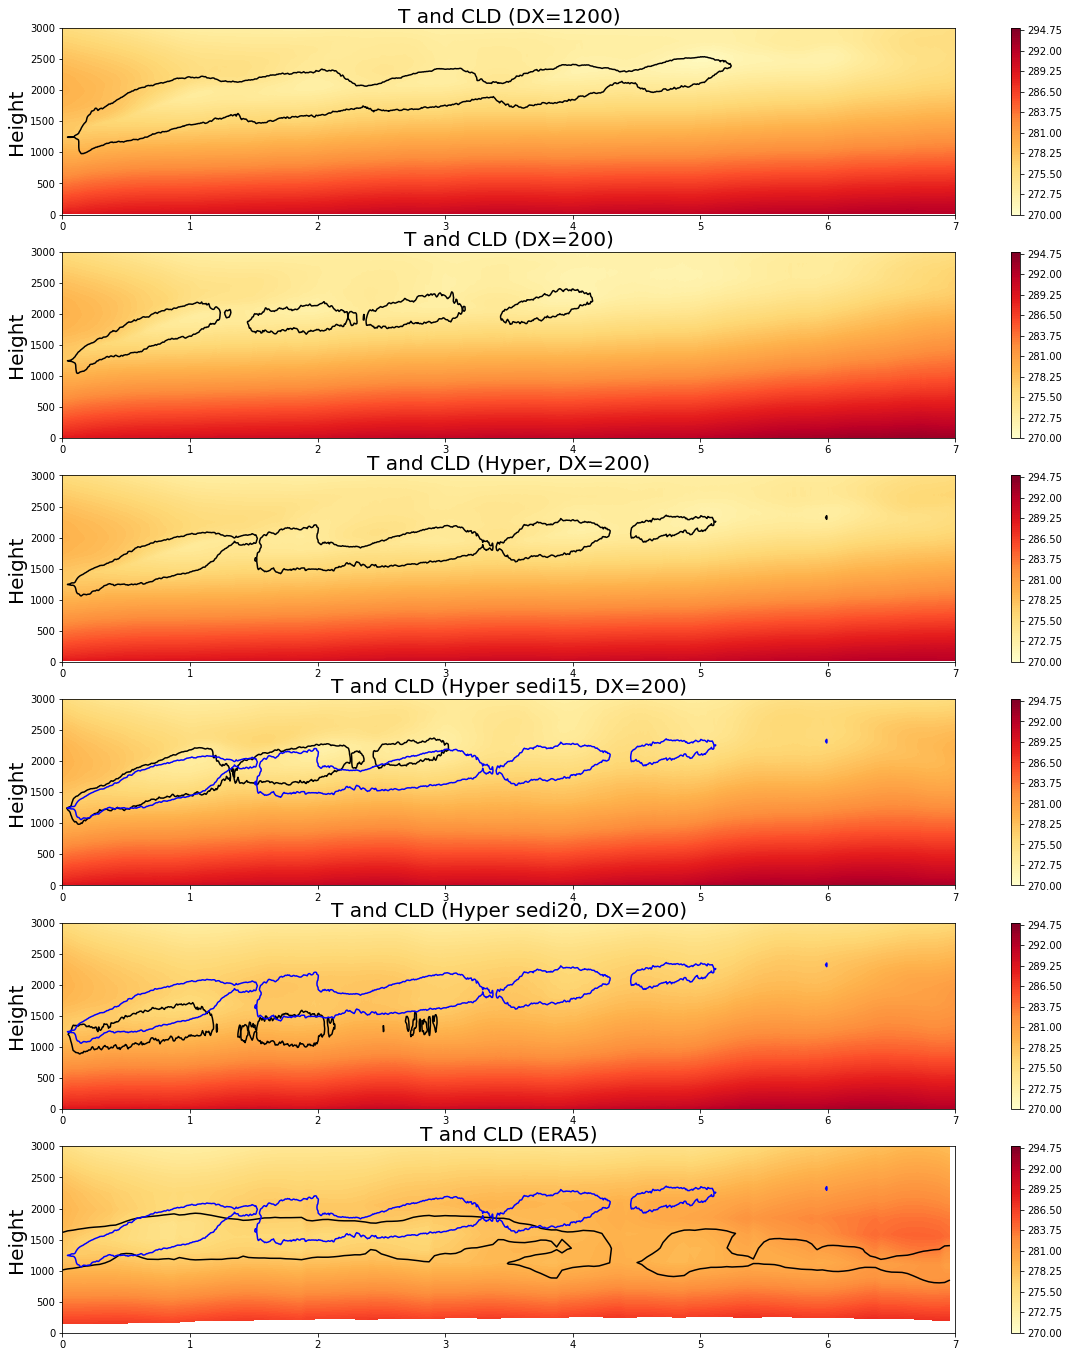

In [71]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [270]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPAustralian,T_crossSPAustralian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPAustralian,cld_crossSPAustralian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPAustralian,T_crossUPAustralian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPAustralian,cld_crossUPAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyAustralian,T_crossUPhyAustralian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Australian,T_crossUPhysedi15Australian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Australian,cld_crossUPhysedi15Australian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Australian,T_crossUPhysedi20Australian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Australian,cld_crossUPhysedi20Australian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zAustralian/9.8,ERA5_tAustralian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zAustralian/9.8,ERA5_ccAustralian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Australian_Time_Height_Model_ERA5.png')

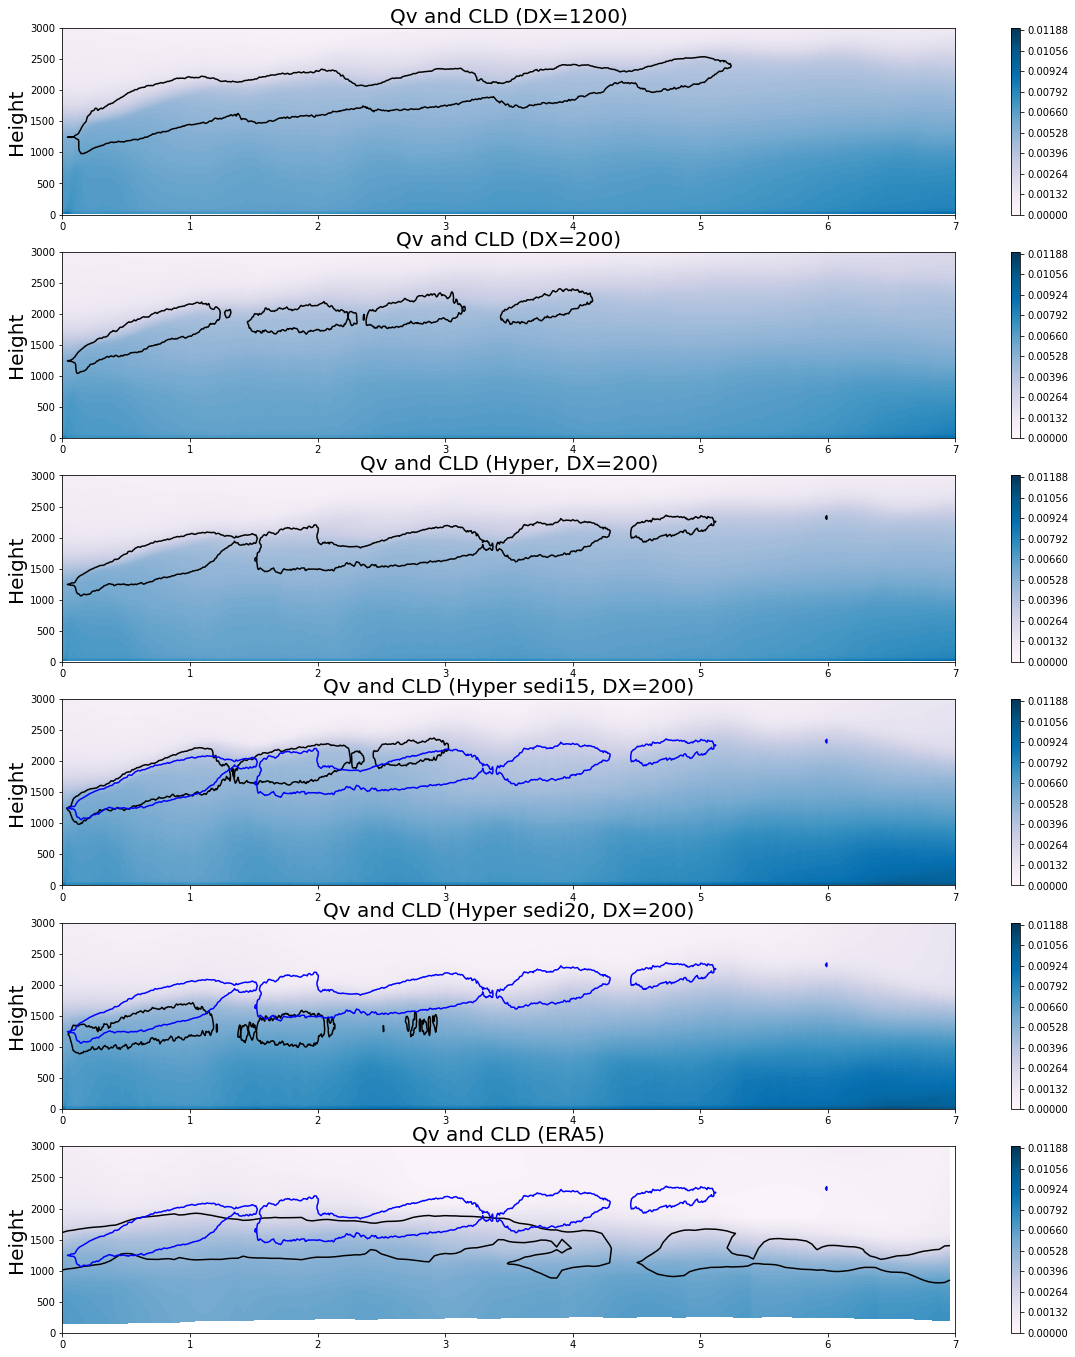

In [192]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPAustralian,Q_crossSPAustralian,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPAustralian,cld_crossSPAustralian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPAustralian,Q_crossUPAustralian,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPAustralian,cld_crossUPAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyAustralian,Q_crossUPhyAustralian,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Australian,Q_crossUPhysedi15Australian,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Australian,cld_crossUPhysedi15Australian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Australian,Q_crossUPhysedi20Australian,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Australian,cld_crossUPhysedi20Australian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zAustralian/9.8,ERA5_qAustralian,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zAustralian/9.8,ERA5_ccAustralian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyAustralian,cld_crossUPhyAustralian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Australian_Time_HeighQv_Model_ERA5.png')

0
24
1
24
2
24
3
24
4
24
5
24
6
24


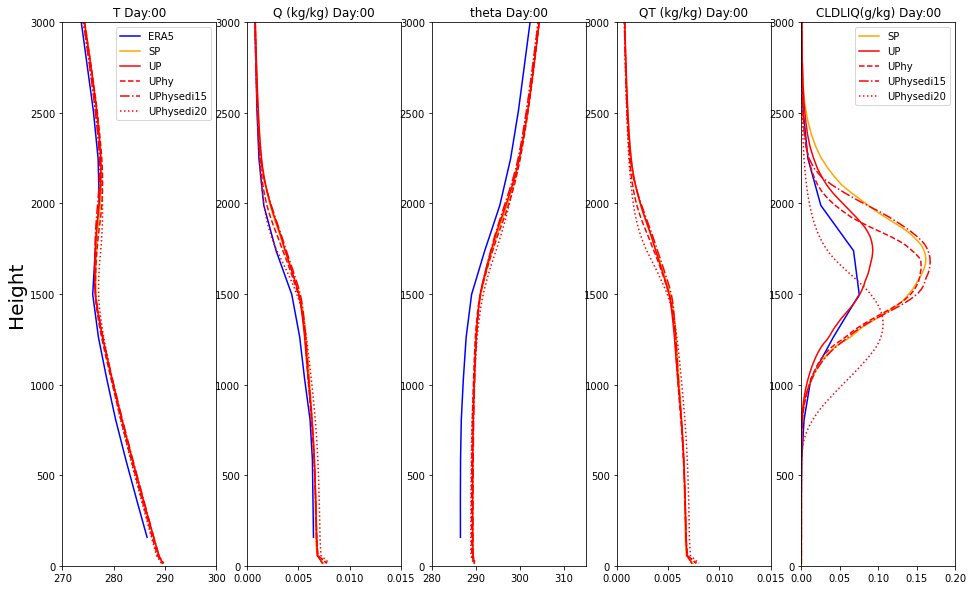

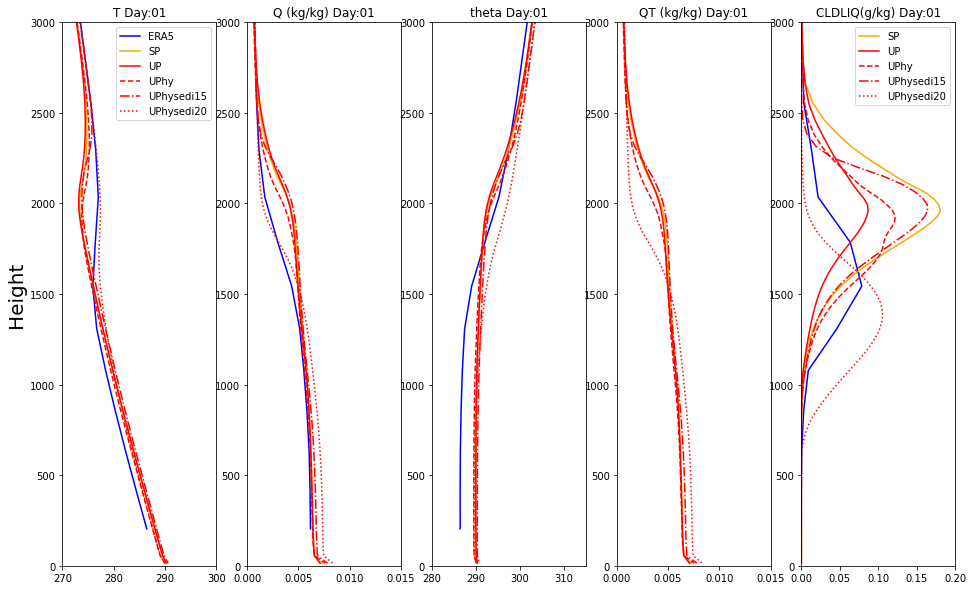

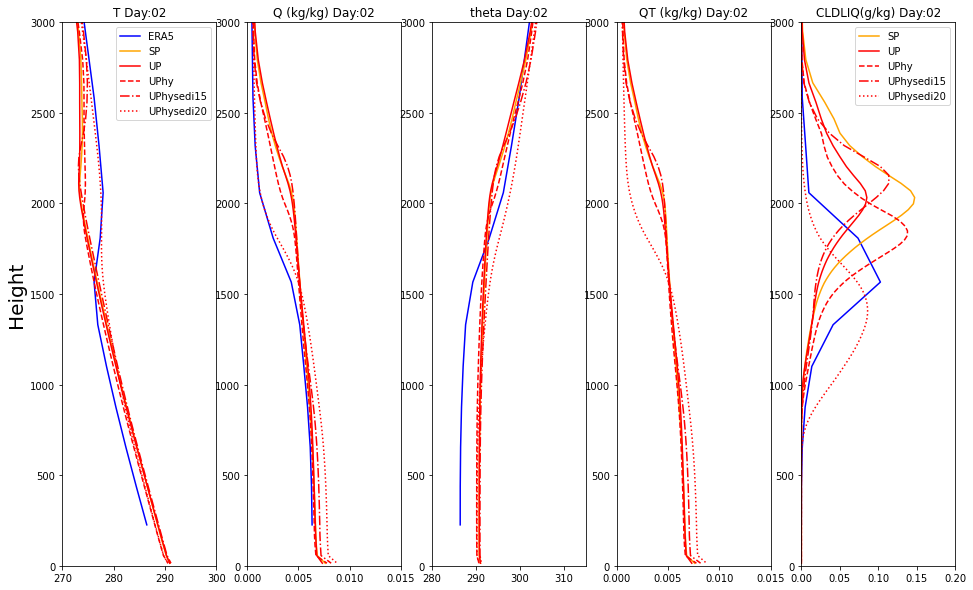

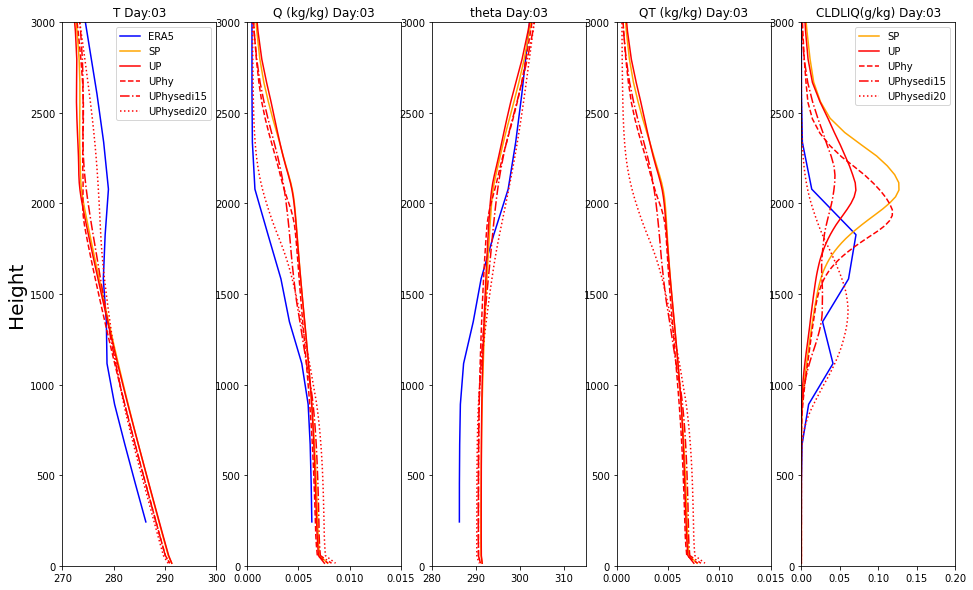

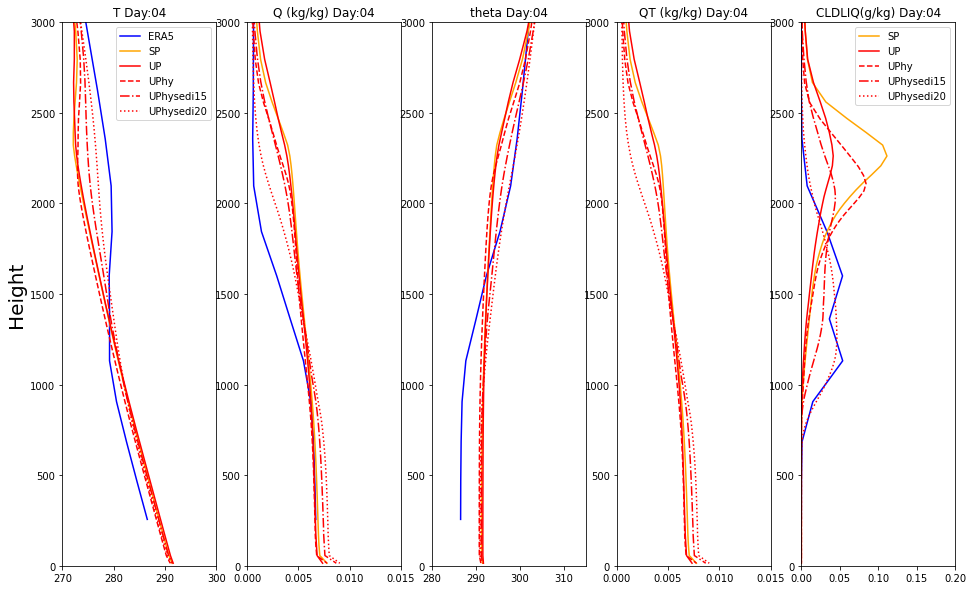

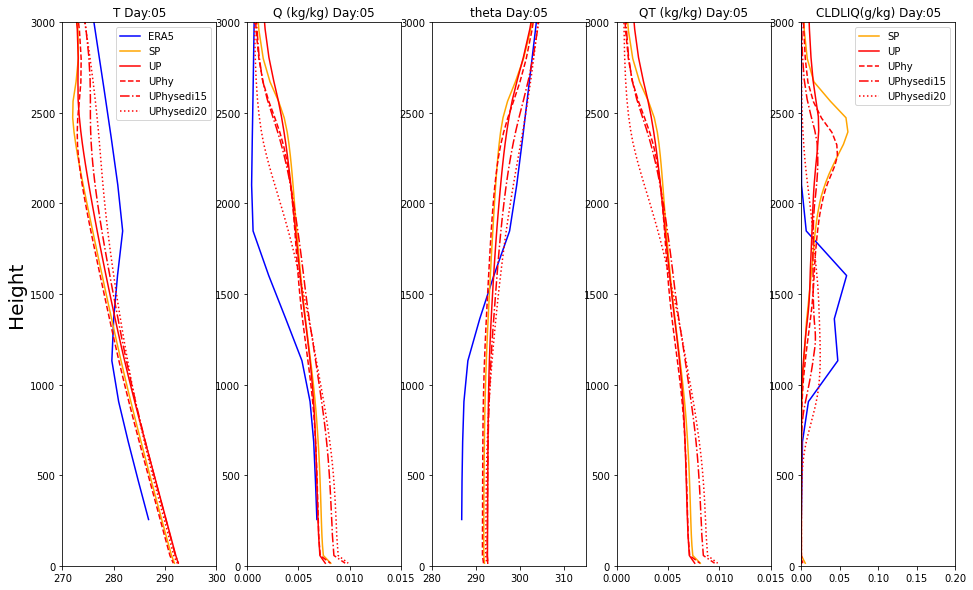

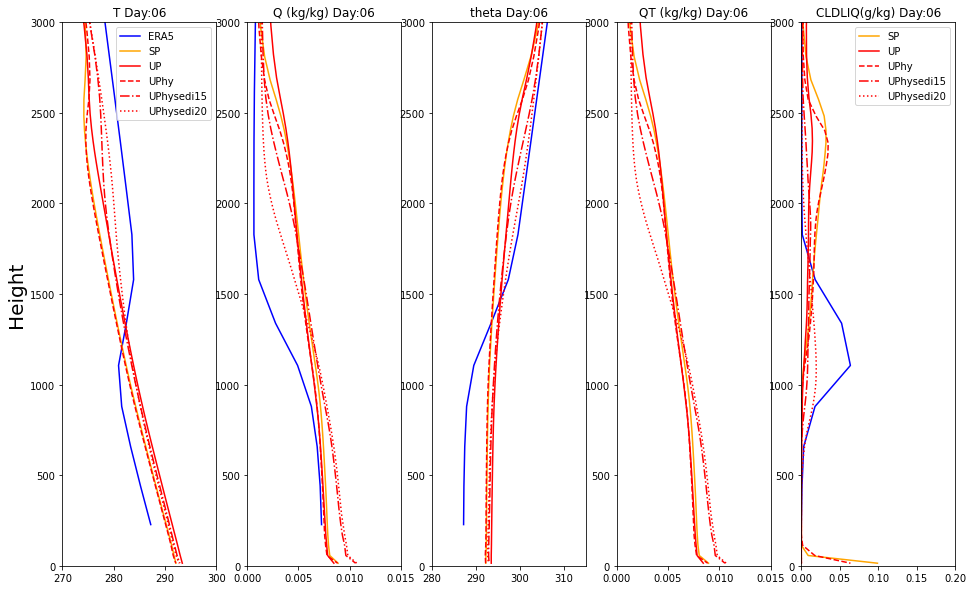

In [188]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Australian_dm = np.zeros([16])
    q_crossERA5Australian_dm = np.zeros([16])
    z_crossERA5Australian_dm = np.zeros([16])
    theta_crossERA5Australian_dm = np.zeros([16])
    lw_crossERA5Australian_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Australian_dm[:] = T_crossERA5Australian_dm[:] + ERA5_tAustralian[(countday+24*iday),:]
        q_crossERA5Australian_dm[:] = q_crossERA5Australian_dm[:] + ERA5_qAustralian[(countday+24*iday),:]
        z_crossERA5Australian_dm[:] = z_crossERA5Australian_dm[:] + ERA5_zAustralian[(countday+24*iday),:]
        lw_crossERA5Australian_dm[:] = lw_crossERA5Australian_dm[:] + ERA5_lwAustralian[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Australian_dm[izz] = potential_temperature(T_crossERA5Australian_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Australian_dm[:] = T_crossERA5Australian_dm[:]/(countday)
    q_crossERA5Australian_dm[:] = q_crossERA5Australian_dm[:]/(countday)
    z_crossERA5Australian_dm[:] = z_crossERA5Australian_dm[:]/(countday)
    theta_crossERA5Australian_dm[:] = theta_crossERA5Australian_dm[:]/(countday)
    lw_crossERA5Australian_dm[:] = lw_crossERA5Australian_dm[:]/(countday)
    T_crossSPAustralian_dm = np.zeros([125])
    T_crossUPAustralian_dm = np.zeros([125])
    T_crossUPhyAustralian_dm = np.zeros([125])
    T_crossUPhysedi15Australian_dm = np.zeros([125])
    T_crossUPhysedi20Australian_dm = np.zeros([125])
    Q_crossSPAustralian_dm = np.zeros([125])
    Q_crossUPAustralian_dm = np.zeros([125])
    Q_crossUPhyAustralian_dm = np.zeros([125])
    Q_crossUPhysedi15Australian_dm = np.zeros([125])
    Q_crossUPhysedi20Australian_dm = np.zeros([125])
    CLDICE_crossSPAustralian_dm = np.zeros([125])
    CLDICE_crossUPAustralian_dm = np.zeros([125])
    CLDICE_crossUPhyAustralian_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Australian_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Australian_dm = np.zeros([125])
    CLDLIQ_crossSPAustralian_dm = np.zeros([125])
    CLDLIQ_crossUPAustralian_dm = np.zeros([125])
    CLDLIQ_crossUPhyAustralian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Australian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Australian_dm = np.zeros([125])
    Z3_crossSPAustralian_dm = np.zeros([125])
    Z3_crossUPAustralian_dm = np.zeros([125])
    Z3_crossUPhyAustralian_dm = np.zeros([125])
    Z3_crossUPhysedi15Australian_dm = np.zeros([125])
    Z3_crossUPhysedi20Australian_dm = np.zeros([125])
    theta_crossSPAustralian_dm = np.zeros([125])
    theta_crossUPAustralian_dm = np.zeros([125])
    theta_crossUPhyAustralian_dm = np.zeros([125])
    theta_crossUPhysedi15Australian_dm = np.zeros([125])
    theta_crossUPhysedi20Australian_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPAustralian_dm[:] = T_crossSPAustralian_dm[:] + T_crossSPAustralian[:,isec+144*iday]
        T_crossUPAustralian_dm[:] = T_crossUPAustralian_dm[:] + T_crossUPAustralian[:,isec+144*iday]
        T_crossUPhyAustralian_dm[:] = T_crossUPhyAustralian_dm[:] + T_crossUPhyAustralian[:,isec+144*iday]
        T_crossUPhysedi15Australian_dm[:] = T_crossUPhysedi15Australian_dm[:] + T_crossUPhysedi15Australian[:,isec+144*iday]
        T_crossUPhysedi20Australian_dm[:] = T_crossUPhysedi20Australian_dm[:] + T_crossUPhysedi20Australian[:,isec+144*iday]
        Q_crossSPAustralian_dm[:] = Q_crossSPAustralian_dm[:] + Q_crossSPAustralian[:,isec+144*iday]
        Q_crossUPAustralian_dm[:] = Q_crossUPAustralian_dm[:] + Q_crossUPAustralian[:,isec+144*iday]
        Q_crossUPhyAustralian_dm[:] = Q_crossUPhyAustralian_dm[:] + Q_crossUPhyAustralian[:,isec+144*iday]
        Q_crossUPhysedi15Australian_dm[:] = Q_crossUPhysedi15Australian_dm[:] + Q_crossUPhysedi15Australian[:,isec+144*iday]
        Q_crossUPhysedi20Australian_dm[:] = Q_crossUPhysedi20Australian_dm[:] + Q_crossUPhysedi20Australian[:,isec+144*iday]
        CLDLIQ_crossSPAustralian_dm[:] = CLDLIQ_crossSPAustralian_dm[:] + CLDLIQ_crossSPAustralian[:,isec+144*iday]
        CLDLIQ_crossUPAustralian_dm[:] = CLDLIQ_crossUPAustralian_dm[:] + CLDLIQ_crossUPAustralian[:,isec+144*iday]
        CLDLIQ_crossUPhyAustralian_dm[:] = CLDLIQ_crossUPhyAustralian_dm[:] + CLDLIQ_crossUPhyAustralian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Australian_dm[:] = CLDLIQ_crossUPhysedi15Australian_dm[:] + CLDLIQ_crossUPhysedi15Australian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Australian_dm[:] = CLDLIQ_crossUPhysedi20Australian_dm[:] + CLDLIQ_crossUPhysedi20Australian[:,isec+144*iday]
        CLDICE_crossSPAustralian_dm[:] = CLDICE_crossSPAustralian_dm[:] + CLDICE_crossSPAustralian[:,isec+144*iday]
        CLDICE_crossUPAustralian_dm[:] = CLDICE_crossUPAustralian_dm[:] + CLDICE_crossUPAustralian[:,isec+144*iday]
        CLDICE_crossUPhyAustralian_dm[:] = CLDICE_crossUPhyAustralian_dm[:] + CLDICE_crossUPhyAustralian[:,isec+144*iday]
        CLDICE_crossUPhysedi15Australian_dm[:] = CLDICE_crossUPhysedi15Australian_dm[:] + CLDICE_crossUPhysedi15Australian[:,isec+144*iday]
        CLDICE_crossUPhysedi20Australian_dm[:] = CLDICE_crossUPhysedi20Australian_dm[:] + CLDICE_crossUPhysedi20Australian[:,isec+144*iday]
        Z3_crossSPAustralian_dm[:] = Z3_crossSPAustralian_dm[:] + Z3_crossSPAustralian[:,isec+144*iday]
        Z3_crossUPAustralian_dm[:] = Z3_crossUPAustralian_dm[:] + Z3_crossUPAustralian[:,isec+144*iday]
        Z3_crossUPhyAustralian_dm[:] = Z3_crossUPhyAustralian_dm[:] + Z3_crossUPhyAustralian[:,isec+144*iday]
        Z3_crossUPhysedi15Australian_dm[:] = Z3_crossUPhysedi15Australian_dm[:] + Z3_crossUPhysedi15Australian[:,isec+144*iday]
        Z3_crossUPhysedi20Australian_dm[:] = Z3_crossUPhysedi20Australian_dm[:] + Z3_crossUPhysedi20Australian[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPAustralian_dm[izz] = theta_crossSPAustralian_dm[izz] + potential_temperature(T_crossSPAustralian[izz,isec+144*iday],P_crossSPAustralian[izz,isec+144*iday]*100)
            #theta_crossUPAustralian_dm[izz] = theta_crossUPAustralian_dm[izz] + potential_temperature(T_crossUPAustralian[izz,isec+144*iday],P_crossUPAustralian[izz,isec+144*iday]*100)
            #theta_crossUPhyAustralian_dm[izz] = theta_crossUPhyAustralian_dm[izz] + potential_temperature(T_crossUPhyAustralian[izz,isec+144*iday],P_crossUPhyAustralian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Australian_dm[izz] = theta_crossUPhysedi15Australian_dm[izz] + potential_temperature(T_crossUPhysedi15Australian[izz,isec+144*iday],P_crossUPhysedi15Australian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Australian_dm[izz] = theta_crossUPhysedi20Australian_dm[izz] + potential_temperature(T_crossUPhysedi20Australian[izz,isec+144*iday],P_crossUPhysedi20Australian[izz,isec+144*iday]*100)
            theta_crossSPAustralian_dm[izz] = theta_crossSPAustralian_dm[izz] + potential_temperature(T_crossSPAustralian[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPAustralian_dm[izz] = theta_crossUPAustralian_dm[izz] + potential_temperature(T_crossUPAustralian[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyAustralian_dm[izz] = theta_crossUPhyAustralian_dm[izz] + potential_temperature(T_crossUPhyAustralian[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Australian_dm[izz] = theta_crossUPhysedi15Australian_dm[izz] + potential_temperature(T_crossUPhysedi15Australian[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Australian_dm[izz] = theta_crossUPhysedi20Australian_dm[izz] + potential_temperature(T_crossUPhysedi20Australian[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPAustralian_dm = T_crossSPAustralian_dm/(countsec)
    T_crossUPAustralian_dm = T_crossUPAustralian_dm/(countsec)
    T_crossUPhyAustralian_dm = T_crossUPhyAustralian_dm/(countsec)
    T_crossUPhysedi15Australian_dm = T_crossUPhysedi15Australian_dm/(countsec)
    T_crossUPhysedi20Australian_dm = T_crossUPhysedi20Australian_dm/(countsec)
    Q_crossSPAustralian_dm = Q_crossSPAustralian_dm/(countsec)
    Q_crossUPAustralian_dm = Q_crossUPAustralian_dm/(countsec)
    Q_crossUPhyAustralian_dm = Q_crossUPhyAustralian_dm/(countsec)
    Q_crossUPhysedi15Australian_dm = Q_crossUPhysedi15Australian_dm/(countsec)
    Q_crossUPhysedi20Australian_dm = Q_crossUPhysedi20Australian_dm/(countsec)  
    CLDICE_crossSPAustralian_dm = CLDICE_crossSPAustralian_dm/(countsec)
    CLDICE_crossUPAustralian_dm = CLDICE_crossUPAustralian_dm/(countsec)
    CLDICE_crossUPhyAustralian_dm = CLDICE_crossUPhyAustralian_dm/(countsec)
    CLDICE_crossUPhysedi15Australian_dm = CLDICE_crossUPhysedi15Australian_dm/(countsec)
    CLDICE_crossUPhysedi20Australian_dm = CLDICE_crossUPhysedi20Australian_dm/(countsec)  
    CLDLIQ_crossSPAustralian_dm = CLDLIQ_crossSPAustralian_dm/(countsec)
    CLDLIQ_crossUPAustralian_dm = CLDLIQ_crossUPAustralian_dm/(countsec)
    CLDLIQ_crossUPhyAustralian_dm = CLDLIQ_crossUPhyAustralian_dm/(countsec)
    CLDLIQ_crossUPhysedi15Australian_dm = CLDLIQ_crossUPhysedi15Australian_dm/(countsec)
    CLDLIQ_crossUPhysedi20Australian_dm = CLDLIQ_crossUPhysedi20Australian_dm/(countsec)  
    Z3_crossSPAustralian_dm = Z3_crossSPAustralian_dm/(countsec)
    Z3_crossUPAustralian_dm = Z3_crossUPAustralian_dm/(countsec)
    Z3_crossUPhyAustralian_dm = Z3_crossUPhyAustralian_dm/(countsec)
    Z3_crossUPhysedi15Australian_dm = Z3_crossUPhysedi15Australian_dm/(countsec)
    Z3_crossUPhysedi20Australian_dm = Z3_crossUPhysedi20Australian_dm/(countsec) 
    theta_crossSPAustralian_dm = theta_crossSPAustralian_dm/(countsec)
    theta_crossUPAustralian_dm = theta_crossUPAustralian_dm/(countsec)
    theta_crossUPhyAustralian_dm = theta_crossUPhyAustralian_dm/(countsec)
    theta_crossUPhysedi15Australian_dm = theta_crossUPhysedi15Australian_dm/(countsec)
    theta_crossUPhysedi20Australian_dm = theta_crossUPhysedi20Australian_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Australian_dm,z_crossERA5Australian_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPAustralian_dm,Z3_crossSPAustralian_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPAustralian_dm,Z3_crossUPAustralian_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyAustralian_dm,Z3_crossUPhyAustralian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Australian_dm,Z3_crossUPhysedi15Australian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Australian_dm,Z3_crossUPhysedi20Australian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(270, 300), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Australian_dm,z_crossERA5Australian_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPAustralian_dm,Z3_crossSPAustralian_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPAustralian_dm,Z3_crossUPAustralian_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyAustralian_dm,Z3_crossUPhyAustralian_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Australian_dm,Z3_crossUPhysedi15Australian_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Australian_dm,Z3_crossUPhysedi20Australian_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Australian_dm,z_crossERA5Australian_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPAustralian_dm,Z3_crossSPAustralian_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPAustralian_dm,Z3_crossUPAustralian_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyAustralian_dm,Z3_crossUPhyAustralian_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Australian_dm,Z3_crossUPhysedi15Australian_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Australian_dm,Z3_crossUPhysedi20Australian_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPAustralian_dm = Q_crossSPAustralian_dm+CLDICE_crossSPAustralian_dm+CLDLIQ_crossSPAustralian_dm
    QT_crossUPAustralian_dm = Q_crossUPAustralian_dm+CLDICE_crossUPAustralian_dm+CLDLIQ_crossUPAustralian_dm
    QT_crossUPhyAustralian_dm = Q_crossUPhyAustralian_dm+CLDICE_crossUPhyAustralian_dm+CLDLIQ_crossUPhyAustralian_dm
    QT_crossUPhysedi15Australian_dm = Q_crossUPhysedi15Australian_dm+CLDICE_crossUPhysedi15Australian_dm+CLDLIQ_crossUPhysedi15Australian_dm
    QT_crossUPhysedi20Australian_dm = Q_crossUPhysedi20Australian_dm+CLDICE_crossUPhysedi20Australian_dm+CLDLIQ_crossUPhysedi20Australian_dm
    cf42 = ax4.plot(QT_crossSPAustralian_dm,Z3_crossSPAustralian_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPAustralian_dm,Z3_crossUPAustralian_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyAustralian_dm,Z3_crossUPhyAustralian_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Australian_dm,Z3_crossUPhysedi15Australian_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Australian_dm,Z3_crossUPhysedi20Australian_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Australian_dm,z_crossERA5Australian_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPAustralian_dm,Z3_crossSPAustralian_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPAustralian_dm,Z3_crossUPAustralian_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyAustralian_dm,Z3_crossUPhyAustralian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Australian_dm,Z3_crossUPhysedi15Australian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Australian_dm,Z3_crossUPhysedi20Australian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.2), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Australian_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

In [183]:
Q_crossSPAustralian_dm

array([3.75223714e-06, 3.75045128e-06, 3.71588216e-06, 3.59777343e-06,
       3.46847996e-06, 3.37472275e-06, 3.29684964e-06, 3.19222463e-06,
       3.06863598e-06, 2.95255264e-06, 2.81511135e-06, 2.76249991e-06,
       2.75627073e-06, 2.75385571e-06, 2.74899608e-06, 2.73616671e-06,
       2.71488228e-06, 2.72022112e-06, 2.75943662e-06, 2.87479944e-06,
       3.01587925e-06, 3.11006668e-06, 3.13943550e-06, 3.29655573e-06,
       5.37489223e-06, 1.55877550e-05, 3.91429081e-05, 7.79203543e-05,
       1.30868155e-04, 1.78185538e-04, 2.21552473e-04, 3.15938362e-04,
       4.21193915e-04, 5.07136054e-04, 5.67682631e-04, 6.16064807e-04,
       7.06866735e-04, 8.47225715e-04, 1.04590252e-03, 1.32585274e-03,
       1.70107101e-03, 2.23484378e-03, 2.82184151e-03, 3.28485622e-03,
       3.61632616e-03, 3.85698929e-03, 4.04317121e-03, 4.19252868e-03,
       4.31624691e-03, 4.42082129e-03, 4.51258443e-03, 4.59276243e-03,
       4.66432825e-03, 4.72905034e-03, 4.78902209e-03, 4.84519054e-03,
      